In [1267]:
import pandas as pd
import re


green_bonds = pd.read_excel("/Users/Panos/Downloads/green_bonds_with_rating.xlsx", header=0)
conv_bonds_1 = pd.read_excel("/Users/Panos/Downloads/conv_bonds1.xlsx", header=0)
conv_bonds_2 = pd.read_excel("/Users/Panos/Downloads/conv_bonds2.xlsx", header=0)
conv_bonds_3 = pd.read_excel("/Users/Panos/Downloads/conv_bonds_3.xlsx", header=0)

print(green_bonds.columns)
print(conv_bonds_1.columns)
print(conv_bonds_2.columns)
print(conv_bonds_3.columns)

Index(['Issuer Name', 'Issue Date', 'Maturity', 'Cpn', 'Moody Rtg',
       'S&P Rating', 'Currency', 'Moody's Issuer Rtg', 'S&P Issuer Rating',
       'Yld to Mty (Mid)', 'Project Category'],
      dtype='object')
Index(['Issuer Name', 'Issue Date', 'Maturity', 'Cpn', 'Moody Rtg',
       'S&P Rating', 'Currency', 'Issuer Rating', 'Yld to Mty (Mid)'],
      dtype='object')
Index(['Issuer Name', 'Issue Date', 'Maturity', 'Cpn', 'Moody Rtg',
       'S&P Rating', 'Currency', 'Issuer Rating', 'Yld to Mty (Mid)'],
      dtype='object')
Index(['Issuer Name', 'Issue Date', 'Maturity', 'Cpn', 'Moody Rtg',
       'S&P Rating', 'Currency', 'Moody's Issuer Rtg', 'S&P Issuer Rating',
       'Yld to Mty (Mid)'],
      dtype='object')


In [1268]:
conv_bonds_3 = conv_bonds_3.drop(columns=['Moody\'s Issuer Rtg'])
conv_bonds_3 = conv_bonds_3.rename(columns={'S&P Issuer Rating': 'Issuer Rating'})

conv_bonds = pd.concat([conv_bonds_1, conv_bonds_2, conv_bonds_3])


In [1269]:
# Define a dictionary that maps Moody's ratings to S&P ratings
ratings_map = {
    'Aaa': 'AAA',
    'Aa1': 'AA+',
    'Aa2': 'AA',
    'Aa3': 'AA-',
    'A1': 'A+',
    'A2': 'A',
    'A3': 'A-',
    'Baa1': 'BBB+',
    'Baa2': 'BBB',
    'Baa3': 'BBB-',
    'Baa3': 'BBB-',
    'Ba1': 'BB+',
    'Ba2': 'BB',
    'Ba3': 'BB-',
    'B1': 'B+',
    'B2': 'B',
    'B3': 'B-',
    'Caa1': 'CCC+',
    'Caa2': 'CCC',
    'Caa3': 'CCC-',
    'Ca': 'C',
    'C': 'D'
}


def replace_missing_sp_issuer(row):
    if pd.isnull(row['S&P Issuer Rating']) or row['S&P Issuer Rating'] == 'NR':
        return ratings_map.get(row['Moody\'s Issuer Rtg'], 'NR')
    else:
        return row['S&P Issuer Rating']
    
def replace_missing_sp(row):
    if pd.isnull(row['S&P Rating']) or row['S&P Rating'] == 'NR':
        return ratings_map.get(row['Moody Rtg'], 'NR')
    else:
        return row['S&P Rating']

# Apply the function to each row
green_bonds['S&P Issuer Rating'] = green_bonds.apply(replace_missing_sp_issuer, axis=1)
green_bonds['S&P Rating'] = green_bonds.apply(replace_missing_sp, axis=1)
conv_bonds['S&P Rating'] = conv_bonds.apply(replace_missing_sp, axis=1)


In [1270]:
conv_bonds = conv_bonds.drop(columns=['Moody Rtg'])
green_bonds = green_bonds.drop(columns=['Moody Rtg', 'Moody\'s Issuer Rtg'])
green_bonds = green_bonds.rename(columns={'S&P Issuer Rating': 'Issuer Rating', 'S&P Rating': 'Bond Rating'})
conv_bonds = conv_bonds.rename(columns={'S&P Rating': 'Bond Rating'})

In [1271]:
total_bonds = pd.concat([green_bonds], ignore_index=True)
total_bonds = total_bonds.fillna({ 'Project Category': 'Conventional' })
dropped_rows = total_bonds[total_bonds['Yld to Mty (Mid)'] > 100]

# Print the dropped rows
print("Dropped rows:")
print(dropped_rows)

n_rows_before = total_bonds.shape[0]
total_bonds = total_bonds[total_bonds['Yld to Mty (Mid)'] <= 100]
total_bonds = total_bonds[total_bonds['Yld to Mty (Mid)'] > 0]
n_rows_after = total_bonds.shape[0]

# Number of rows dropped
n_rows_dropped = n_rows_before - n_rows_after

print(n_rows_dropped, n_rows_after)

Dropped rows:
Empty DataFrame
Columns: [Issuer Name, Issue Date, Maturity, Cpn, Bond Rating, Currency, Issuer Rating, Yld to Mty (Mid), Project Category]
Index: []
0 2837


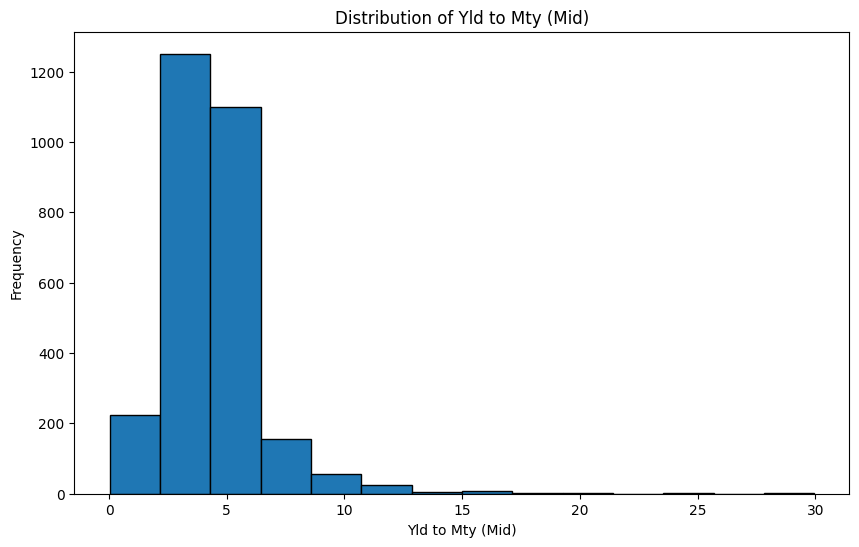

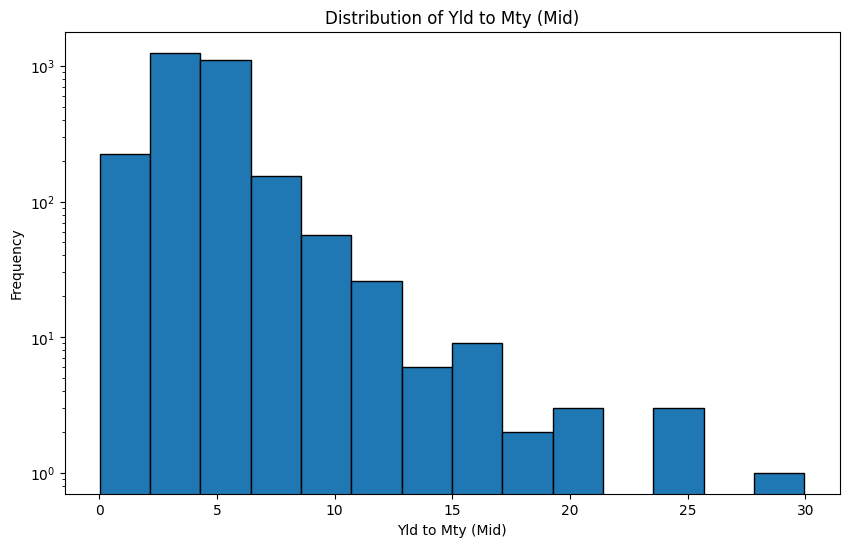

In [1272]:
import matplotlib.pyplot as plt
import seaborn as sns

# Using Matplotlib
plt.figure(figsize=(10,6))
plt.hist(total_bonds['Yld to Mty (Mid)'], bins=14, edgecolor='black')
plt.title('Distribution of Yld to Mty (Mid)')
plt.xlabel('Yld to Mty (Mid)')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10,6))
plt.hist(total_bonds['Yld to Mty (Mid)'], bins=14, edgecolor='black')
plt.title('Distribution of Yld to Mty (Mid)')
plt.xlabel('Yld to Mty (Mid)')
plt.ylabel('Frequency')
plt.yscale('log')
plt.show()


In [1273]:
df_model_rating = total_bonds.drop(columns=['Issuer Name', 'Issue Date', 'Maturity', 'Cpn', 'Currency', 'Yld to Mty (Mid)'])
df_model_ytm = total_bonds.drop(columns=['Bond Rating', 'Project Category'])
print(df_model_rating.columns)
print(df_model_ytm.columns)

Index(['Bond Rating', 'Issuer Rating', 'Project Category'], dtype='object')
Index(['Issuer Name', 'Issue Date', 'Maturity', 'Cpn', 'Currency',
       'Issuer Rating', 'Yld to Mty (Mid)'],
      dtype='object')


In [1274]:
import pandas as pd
import re

def replace_missing_project_cat(row):
    if row['Project Category'] == '#N/A Field Not Applicable':
        return 'undisclosed'
    else:
        return row['Project Category']

# Assuming 'df' is your DataFrame and 'column' is the column of interest
def split_string(s):
    # The regular expression looks for places in the string to split, right before a capital letter
    return re.split(r'(?=[A-Z])', s)

# Apply the split function to each row in the column
df_model_rating['Project Category'] = df_model_rating.apply(replace_missing_project_cat, axis=1)
df_model_rating['Project Category'] = df_model_rating['Project Category'].apply(split_string)


In [1275]:
from dateutil.relativedelta import relativedelta
from datetime import date


def replace_missing_maturity(row):
    if row['Maturity'] == '#N/A Field Not Applicable':
        return '01/01/2070'
    else:
        return row['Maturity']
    
df_model_ytm['Maturity'] = df_model_ytm.apply(replace_missing_maturity, axis=1)

# Split Issue Date into separate columns
df_model_ytm['Issue Day'] = df_model_ytm['Issue Date'].apply(lambda x: int(x.split('/')[0]))
df_model_ytm['Issue Month'] = df_model_ytm['Issue Date'].apply(lambda x: int(x.split('/')[1]))
df_model_ytm['Issue Year'] = df_model_ytm['Issue Date'].apply(lambda x: int(x.split('/')[2]))

# Split Maturity into separate columns
df_model_ytm['Maturity Day'] = df_model_ytm['Maturity'].apply(lambda x: int(x.split('/')[0]))
df_model_ytm['Maturity Month'] = df_model_ytm['Maturity'].apply(lambda x: int(x.split('/')[1]))
df_model_ytm['Maturity Year'] = df_model_ytm['Maturity'].apply(lambda x: int(x.split('/')[2]))


# Function to calculate the number of days between two dates
def days_between(d1, d2):
    return (d2 - d1).days

# Apply the function to each row
df_model_ytm['Days to Maturity'] = df_model_ytm.apply(
    lambda row: days_between(
        date(row['Issue Year'], row['Issue Month'], row['Issue Day']),
        date(row['Maturity Year'], row['Maturity Month'], row['Maturity Day'])
    ), 
    axis=1
)

df_model_ytm = df_model_ytm.drop(columns=['Maturity', 'Maturity Year', 'Maturity Month', 'Maturity Day', 'Issue Date', 'Issuer Name'])



In [1276]:
df_model_ytm = pd.get_dummies(df_model_ytm, columns=['Currency'])


In [1277]:
# Remember original order
# original_order = df_model_ytm.index

# # Sort df by column 'A'
# df_model_ytm = df_model_ytm.sort_values('Yld to Mty (Mid)', ascending=True)

# # Enumerate column 'B'
# df_model_ytm['Issuer Name'] = df_model_ytm.groupby('Issuer Name').ngroup()

# # Restore original order
# df_model_ytm = df_model_ytm.reindex(original_order)


In [1278]:
ratings_mapping = {'AAA': 22, 'AA+': 21, 'AA': 20, 'AA-': 19, 'A+': 18, 'A': 17, 
                   'A-': 16, 'BBB+': 15, 'BBB': 14, 'BBB-': 13, 'BB+': 12, 'BB': 11, 
                   'BB-': 10, 'B+': 9, 'B': 8, 'B-': 7, 'CCC+': 6, 'CCC': 5, 'CCC-': 4, 
                   'CC': 3, 'C': 2, 'D': 1, 'NR': 0}

ratings_mapping = {k: 22-v for k, v in ratings_mapping.items()}

df_model_ytm['Issuer Rating'] = df_model_ytm['Issuer Rating'].map(ratings_mapping)
df_model_ytm['Issuer Rating'] = df_model_ytm['Issuer Rating'].fillna('0')


In [1279]:
print(df_model_ytm.columns)

Index(['Cpn', 'Issuer Rating', 'Yld to Mty (Mid)', 'Issue Day', 'Issue Month',
       'Issue Year', 'Days to Maturity', 'Currency_AUD', 'Currency_BRL',
       'Currency_CAD', 'Currency_CHF', 'Currency_CLP', 'Currency_CNY',
       'Currency_COP', 'Currency_CZK', 'Currency_DKK', 'Currency_EUR',
       'Currency_GBP', 'Currency_HKD', 'Currency_HUF', 'Currency_IDR',
       'Currency_INR', 'Currency_JPY', 'Currency_KRW', 'Currency_MXN',
       'Currency_NGN', 'Currency_NOK', 'Currency_NZD', 'Currency_PEN',
       'Currency_PHP', 'Currency_PLN', 'Currency_RUB', 'Currency_SEK',
       'Currency_SGD', 'Currency_TWD', 'Currency_USD', 'Currency_UYU',
       'Currency_ZAR'],
      dtype='object')


In [1280]:
from sklearn.preprocessing import StandardScaler

# Define the number of features (don't include 'Issuer' and 'Yld to Mty (Mid)')
num_features_ytm = df_model_ytm.drop(['Yld to Mty (Mid)'], axis=1).shape[1]

# Split your data into features (X) and target (y)
X_num = df_model_ytm.drop(['Yld to Mty (Mid)'], axis=1)
print(X_num.columns)
y = df_model_ytm['Yld to Mty (Mid)']

# Convert all to numpy array and ensure type compatibility

y = y.to_numpy().astype('float32')
# y = y.round(decimals=4)


Index(['Cpn', 'Issuer Rating', 'Issue Day', 'Issue Month', 'Issue Year',
       'Days to Maturity', 'Currency_AUD', 'Currency_BRL', 'Currency_CAD',
       'Currency_CHF', 'Currency_CLP', 'Currency_CNY', 'Currency_COP',
       'Currency_CZK', 'Currency_DKK', 'Currency_EUR', 'Currency_GBP',
       'Currency_HKD', 'Currency_HUF', 'Currency_IDR', 'Currency_INR',
       'Currency_JPY', 'Currency_KRW', 'Currency_MXN', 'Currency_NGN',
       'Currency_NOK', 'Currency_NZD', 'Currency_PEN', 'Currency_PHP',
       'Currency_PLN', 'Currency_RUB', 'Currency_SEK', 'Currency_SGD',
       'Currency_TWD', 'Currency_USD', 'Currency_UYU', 'Currency_ZAR'],
      dtype='object')


In [1281]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ModelYTM(nn.Module):
    def __init__(self, num_features_ytm):
        super(ModelYTM, self).__init__()
        self.num_features_ytm = num_features_ytm
        
        self.dense1 = nn.Linear(num_features_ytm, 65)
        self.dense2 = nn.Linear(65, 65)
        self.dense4 = nn.Linear(65, 65)
        self.dense5 = nn.Linear(65, 5)
        self.output_layer = nn.Linear(5, 1)
        
    def forward(self, num_input):

        x = F.leaky_relu(self.dense1(num_input))
        x = F.leaky_relu(self.dense2(x))
        x = F.leaky_relu(self.dense4(x))
        x = F.leaky_relu(self.dense5(x))
        output = self.output_layer(x)
        
        return output


In [1282]:
import numpy as np

# X_num_test = X_num
# nan_indices = np.where(np.isnan(X_num_test))
# print(nan_indices)
# nan_indices = np.where(np.isnan(X_num_test))
# print(nan_indices)
# scaler_rtg = StandardScaler() # make new scaler, we will need the old later to scale the output of the model
# X_num_test = scaler_rtg.fit_transform(X_num_test)
# nan_indices = np.where(np.isnan(X_num_test))

# print(nan_indices)

Test MSE: 1.2963955


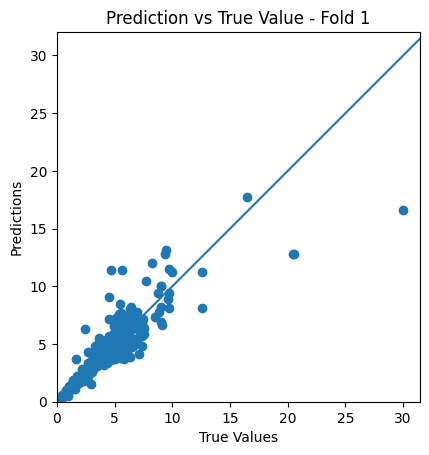

Test MSE: 1.7606694


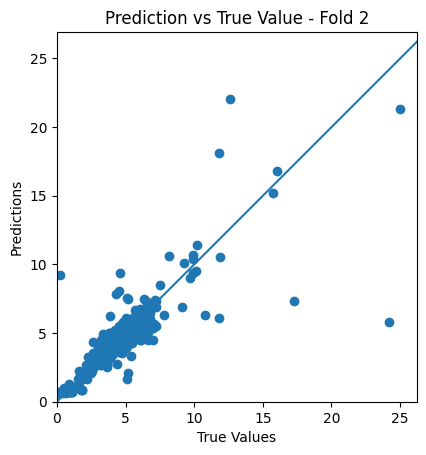

Test MSE: 1.2754598


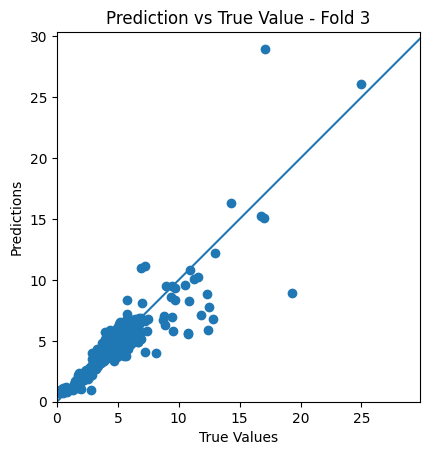

Test MSE: 0.6931758


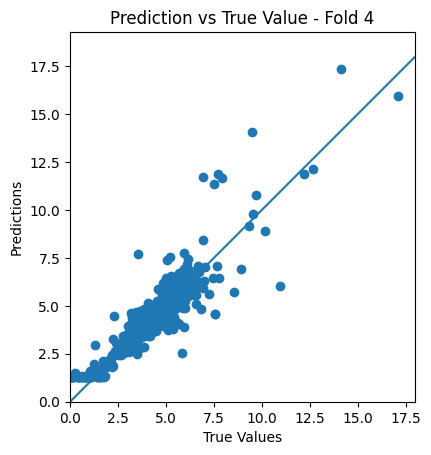

Test MSE: 1.0380179


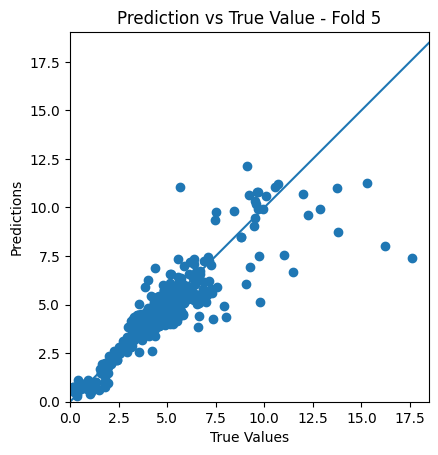

MSE: 1.2127 +/- 0.3498
R^2: 0.7458 +/- 0.0497
MAPE: 0.2293 +/- 0.0939


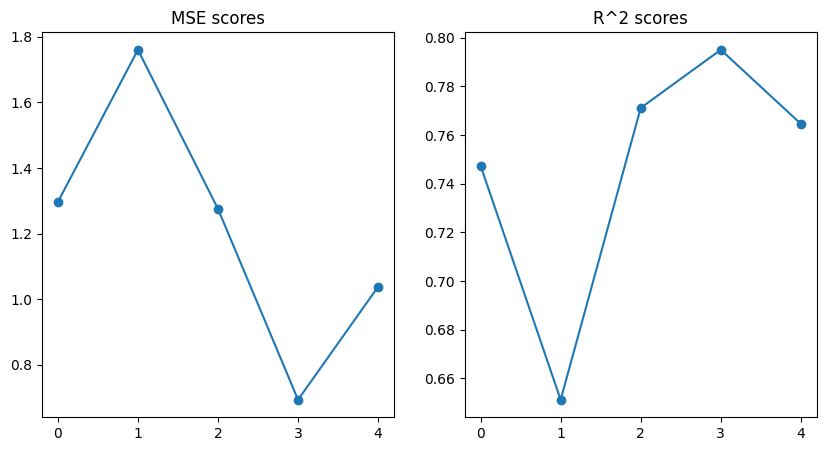

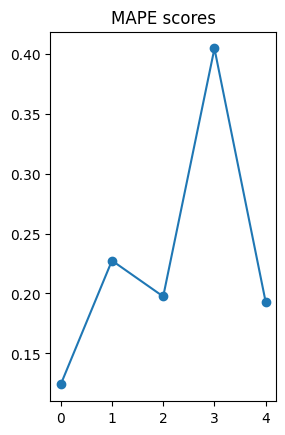

In [1283]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Define a training step
def train_step_init(inputs_num, targets, model, loss_function, optimizer):
    model.train()
    optimizer.zero_grad()
    outputs = model(inputs_num)
    loss = loss_function(outputs, targets.view(-1, 1))
    loss.backward()
    optimizer.step()
    return loss.item()

# Initialize the KFold object
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize lists to store the scores for each fold
mse_scores = []
r2_scores = []
mapes = []
scalers = []
fold_preds = []
fold_targets = []

f = 0
X_num = X_num.to_numpy()  # transform the dataframe to a numpy array
# Loop through each fold
for train_index, test_index in kf.split(X_num, y):
    scalers = []  # Reset scalers for each fold
    X_train, X_test = X_num[train_index], X_num[test_index]
    y_train, y_test = y[train_index], y[test_index]

    for i in range(X_train.shape[1]):
        scaler = StandardScaler()
        scalers.append(scaler)
        X_train[:, i] = scaler.fit_transform(X_train[:, i].reshape(-1, 1)).flatten()  # scale each column
        X_test[:, i] = scaler.transform(X_test[:, i].reshape(-1, 1)).flatten()  # scale each column using the scaler fitted on the training set

    X_train = X_train.astype('float32')  # convert the datatype
    X_test = X_test.astype('float32')  # convert the datatype

    X_train = torch.tensor(X_train)
    X_test = torch.tensor(X_test)
    y_train = torch.tensor(y_train)
    y_test = torch.tensor(y_test)

    # Create a new model for each fold
    model_ytm = ModelYTM(num_features_ytm=num_features_ytm)

    # Define a loss function and optimizer for this fold
    loss_function = nn.MSELoss()
    optimizer = optim.Adagrad(model_ytm.parameters(), lr=0.1)

    # Convert to TensorDataset and create a DataLoader
    train_dataset = TensorDataset(X_train, y_train)
    train_dataloader = DataLoader(train_dataset, shuffle=True)

    # Train the model for each epoch
    for epoch in range(20):
        for inputs_num, targets in train_dataloader:
            train_step_init(inputs_num, targets, model_ytm, loss_function, optimizer)

    # Evaluate the model
    model_ytm.eval()
    with torch.no_grad():
        y_pred = model_ytm(X_test).numpy()

    torch.save(model_ytm.state_dict(), f'model_ytm_fold{f+1}.pth')

    # Calculate and store the scores
    mse = mean_squared_error(y_test, y_pred)
    mse_scores.append(mse)
    r2_scores.append(r2_score(y_test, y_pred))
    mapes.append(mean_absolute_percentage_error(y_test, y_pred))
    fold_preds.append(y_pred)
    fold_targets.append(y_test)

    print("Test MSE:", mse)

    plt.figure(f)
    plt.scatter(y_test, y_pred)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.title('Prediction vs True Value - Fold {}'.format(f+1))
    plt.axis('equal')
    plt.axis('square')
    plt.xlim([0,plt.xlim()[1]])
    plt.ylim([0,plt.ylim()[1]])
    _ = plt.plot([-100, 100], [-100, 100])
    plt.show()
    f += 1

# Print the mean and standard deviation of the MSE and R^2 scores
print('MSE: %.4f +/- %.4f' % (np.mean(mse_scores), np.std(mse_scores)))
print('R^2: %.4f +/- %.4f' % (np.mean(r2_scores), np.std(r2_scores)))
print('MAPE: %.4f +/- %.4f' % (np.mean(mapes), np.std(mapes)))

# Plot the MSE scores
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(mse_scores, marker='o')
plt.title('MSE scores')

# Plot the R^2 scores
plt.subplot(1, 2, 2)
plt.plot(r2_scores, marker='o')
plt.title('R^2 scores')
plt.show()

plt.subplot(1, 2, 2)
plt.plot(mapes, marker='o')
plt.title('MAPE scores')
plt.show()


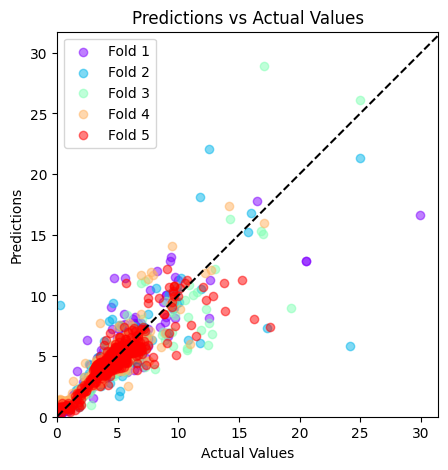

In [1284]:
# Create color map with a unique color for each fold
colors = plt.cm.rainbow(np.linspace(0, 1, 5))

# Create the figure
plt.figure(figsize=(10,5))

for fold in range(5):
    # Scatter the predictions against the actual values for each fold
    plt.scatter(fold_targets[fold], fold_preds[fold], color=colors[fold], alpha=0.5, label=f'Fold {fold+1}')

# Set title and labels
plt.title('Predictions vs Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])

# Plot the identity line
_ = plt.plot([-100, 100], [-100, 100], color='black', linestyle='--')

# Add a legend
plt.legend()

# Show the plot
plt.show()


# Model to predict new rating

In [1285]:
from sklearn.preprocessing import MultiLabelBinarizer

# 1. Remove empty strings from lists
df_model_rating['Project Category'] = df_model_rating['Project Category'].apply(lambda x: [i.strip() for i in x if i])

# 2. One-hot encode the lists
mlb = MultiLabelBinarizer()
one_hot = mlb.fit_transform(df_model_rating['Project Category'])
one_hot_df = pd.DataFrame(one_hot, columns=mlb.classes_)

# Merge the one-hot encoded features back into the original dataframe
df_model_rating = df_model_rating.join(one_hot_df)
df_model_rating = df_model_rating.drop(columns=['Project Category'])

In [1286]:
df_model_rating['Issuer Rating'] = df_model_rating['Issuer Rating'].map(ratings_mapping)
df_model_rating['Bond Rating'] = df_model_rating['Bond Rating'].map(ratings_mapping)


In [1321]:
import torch.nn as nn
import torch.nn.functional as F

class ModelRating(nn.Module):
    def __init__(self, n_features_rtg):
        super(ModelRating, self).__init__()
        self.fc1 = nn.Linear(n_features_rtg, 5)
        self.fc2 = nn.Linear(5,5)
        self.fc3 = nn.Linear(5,5)
        self.fc4 = nn.Linear(5,1)


    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# Instantiate the model
n_features_rtg = df_model_rating.shape[1]
model_rating = ModelRating(n_features_rtg)


In [1288]:
# Get the indices where there are NaN values in each DataFrame
nan_indices_model_rating = df_model_rating[df_model_rating.isna().any(axis=1)].index
nan_indices_model_ytm = df_model_ytm[df_model_ytm.isna().any(axis=1)].index

# Combine the indices
all_nan_indices = nan_indices_model_rating.union(nan_indices_model_ytm)

print("Indices to remove:")
print(all_nan_indices)

# Drop these indices from both DataFrames
df_model_rating = df_model_rating.drop(all_nan_indices)
df_model_ytm = df_model_ytm.drop(all_nan_indices)

print("Shapes after removing rows with NaNs:")
print(df_model_rating.shape)
print(df_model_ytm.shape)


Indices to remove:
Index([1089, 1476, 1531], dtype='int64')
Shapes after removing rows with NaNs:
(2834, 13)
(2834, 38)


In [1289]:
# from sklearn.model_selection import train_test_split


# X_model1_train, X_model1_test, y_model2_train, y_model2_test = train_test_split(df_model_rating, df_model_ytm['Yld to Mty (Mid)'], test_size=0.2, random_state=42)

# X_model2_train = X_num[X_model1_train.index]
# X_model2_test = X_num[X_model1_test.index]
# nan_indices = np.where(np.isnan(df_model_rating))
# print(nan_indices)


In [1290]:
# print(np.shape(X_model1_train))
# print(np.shape(X_model2_train))
# print(type(X_model2_train[0]))
# print(type(X_model2_train[1]))
# print(type(X_model1_train))

In [1291]:
# X_num_rtg = X_model1_train
# print(X_model1_train.columns)
# nan_indices = np.where(np.isnan(X_num_rtg))
# print(nan_indices)
# nan_indices = np.where(np.isnan(X_num_rtg))
# print(nan_indices)
# X_num_rtg = X_num_rtg.to_numpy()  # transform the dataframe to a numpy array

# for i in range(X_num_rtg.shape[1]):
#     scaler = StandardScaler()
#     if i == 2:
#         scaler = scalers[2]
#     X_num_rtg[:, i] = scaler.fit_transform(X_num_rtg[:, i].reshape(-1, 1)).flatten()  # scale each column

# X_num_rtg = X_num_rtg.astype('float32')  # convert the datatype

# nan_indices = np.where(np.isnan(X_num_rtg))

# print(nan_indices)

In [1292]:
# X_num_rtg_test = X_model1_test
# nan_indices = np.where(np.isnan(X_num_rtg_test))
# print(nan_indices)
# X_num_rtg_test = X_num_rtg_test.to_numpy().astype('float32')
# nan_indices = np.where(np.isnan(X_num_rtg_test))
# print(nan_indices)
# scaler_rtg = StandardScaler() # make new scaler, we will need the old later to scale the output of the model
# X_num_rtg_test = scaler_rtg.fit_transform(X_num_rtg_test)
# nan_indices = np.where(np.isnan(X_num_rtg_test))

# print(nan_indices)

In [1293]:
import torch
from torch import nn, optim
from torch.nn.utils import clip_grad_norm_

class Model(nn.Module):
    def __init__(self, model_rating, model_ytm):
        super(Model, self).__init__()
        self.model_rating = model_rating
        self.model_ytm = model_ytm

    def forward(self, inputs_model1, inputs_model2_num):
        # outputs1 = self.model_rating(torch.cat([inputs_model1[:,1].unsqueeze(-1), inputs_model2_num[:,2].unsqueeze(-1), inputs_model1[:,2:]], dim=-1))
        outputs1 = self.model_rating(inputs_model1)

        inputs_model2_combined = torch.cat([inputs_model2_num[:, :1], outputs1, inputs_model2_num[:, 2:]], dim=-1)

        outputs2 = self.model_ytm(inputs_model2_combined)
        return outputs1, outputs2

model_rating = ModelRating(n_features_rtg=n_features_rtg)
model_ytm = ModelYTM(num_features_ytm=num_features_ytm)
model = Model(model_rating, model_ytm)

optimizer = optim.Adam(model.parameters(), lr=0.00001)
loss_function = nn.MSELoss()

def train_step(inputs_model1, inputs_model2_num, targets, optimizer=optimizer):
    optimizer.zero_grad()

    outputs1, outputs2 = model(inputs_model1, inputs_model2_num)

    loss = loss_function(outputs2[0], targets)
    loss.backward()

    optimizer.step()

    return loss

def train_step_diff(inputs_model1, inputs_model2_num, model_ytm, optimizer):
    optimizer.zero_grad()

    # Pass input through overall model
    output1, outputs_overall = model(inputs_model1, inputs_model2_num)
    # print(f'prediction={output1[0]}, issuer_rating_model1={inputs_model1[:,1]}, issuer_rating_model2={inputs_model2_num[:, 1]}')
    # Pass input through model_ytm separately
    outputs_ytm = model_ytm(inputs_model2_num)

    # Calculate loss based on the difference between the two model outputs
    loss = loss_function(output1[0], inputs_model2_num[:, 2])
    
    loss.backward()
    optimizer.step()

    return loss


In [1294]:
X_num_rtg = df_model_rating.to_numpy()
# scaler_rtg = StandardScaler()
# X_num_rtg = scaler.fit_transform(X_num_rtg)

In [1295]:
# from sklearn.model_selection import KFold
# from sklearn.metrics import mean_absolute_percentage_error

# num_epochs = 10
# num_splits = 5
# kfold = KFold(n_splits=num_splits, shuffle=True, random_state=42)

# # Initializing lists to store losses for each fold
# train_losses = []
# val_losses = []
# r2_scores = []
# fold_targets = []
# fold_predictions = []
# mses = []
# mapes = []
# i = 0
# # Begin cross-validation
# for fold, (train_idx, val_idx) in enumerate(kfold.split(df_model_rating, df_model_ytm['Yld to Mty (Mid)'])):
#     model_ytm = ModelYTM(num_features_ytm=num_features_ytm)
#     model_ytm.load_state_dict(torch.load(f'model_ytm_fold{i+1}.pth'))
#     model_rating = ModelRating(n_features_rtg=n_features_rtg)
#     model = Model(model_rating, model_ytm)

#     optimizer = optim.Adam([
#         {'params': model.model_rating.parameters(), 'lr': 0.0001},
#         {'params': model.model_ytm.parameters(), 'lr': 0.0000001}
#     ])

#     loss_function = nn.MSELoss()
#     # Initialize lists to store epoch losses for this fold
#     epoch_train_losses = []
#     epoch_val_losses = []
#     epoch_r2_scores = []
#     print(f'Fold {fold+1}/{num_splits}')

#     # Further splitting the data into model1 and model2 inputs
#     X_model1_train_fold = X_num_rtg[train_idx]
#     X_model2_train_fold = X_num[train_idx]
#     X_model1_val_fold = X_num_rtg[val_idx]
#     X_model2_val_fold = X_num[val_idx]
#     y_train_fold = df_model_ytm['Yld to Mty (Mid)'].to_numpy()[train_idx]
#     y_val_fold = df_model_ytm['Yld to Mty (Mid)'].to_numpy()[val_idx]

#     # Training loop
#     for epoch in range(num_epochs):
#         running_train_loss = 0.0
#         running_val_loss = 0.0

#         # Training phase
#         model.train()
#         for model1_in, model2_in_num, target in zip(X_model1_train_fold, X_model2_train_fold, y_train_fold):
#             model1_in = torch.tensor(model1_in, dtype=torch.float32).unsqueeze(0)
#             model2_in_num = torch.tensor(model2_in_num, dtype=torch.float32).unsqueeze(0)
#             target = torch.tensor(target, dtype=torch.float32).unsqueeze(0)

#             loss = train_step_diff(model1_in, model2_in_num, target, optimizer)
#             running_train_loss += loss.item()

#         # Validation phase
#         model.eval()
#         with torch.no_grad():
#             outputs = []
#             targets = []
#             for model1_in, model2_in_num, target in zip(X_model1_val_fold, X_model2_val_fold, y_val_fold):
#                 model1_in = torch.tensor(model1_in, dtype=torch.float32).unsqueeze(0)
#                 model2_in_num = torch.tensor(model2_in_num, dtype=torch.float32).unsqueeze(0)
#                 target = torch.tensor(target, dtype=torch.float32).unsqueeze(0)

#                 output_rating, output = model(model1_in, model2_in_num)
#                 # print(output_rating)
#                 output = output[0]
#                 loss = loss_function(output, target)
#                 running_val_loss += loss.item()

#                 outputs.append(output.numpy())
#                 targets.append(target.numpy())
#                 if (output > 35 and target < 10):
#                     print(output, target)
#                     print(model1_in, model2_in_num)
#                     print(output_rating, model2_in_num[:, 1])

#             # Calculate R2 score
#         r2 = r2_score(np.concatenate(targets), np.concatenate(outputs))
#         mape = mean_absolute_percentage_error(np.concatenate(targets), np.concatenate(outputs))
        
#         # Calculate and store epoch losses
#         epoch_train_loss = running_train_loss / len(X_model1_train_fold)
#         epoch_val_loss = running_val_loss / len(X_model1_val_fold)
#         epoch_train_losses.append(epoch_train_loss)
#         epoch_val_losses.append(epoch_val_loss)
#     # Store R2 scores for this fold
#     r2_scores.append(r2)
#     mapes.append(mape)
#     # Store losses for this fold
#     train_losses.append(epoch_train_losses)
#     val_losses.append(epoch_val_losses)
#     mse = epoch_val_loss
#     fold_predictions.append(np.concatenate(outputs))
#     fold_targets.append(np.concatenate(targets))

#     # Plotting
#     plt.figure(figsize=(10, 5))

#     # Create an x-axis range
#     x_values = range(1, num_epochs + 1)

#     # Plot both training and validation MSE values
#     plt.plot(x_values, train_losses[i], label='Training Loss')
#     plt.plot(x_values, val_losses[i], label='Validation Loss')

#     # Adding title and labels
#     plt.title('Training and Validation Loss across Epochs')
#     plt.xlabel('Epochs')
#     plt.ylabel('Mean Squared Error')
#     plt.legend()

#     # Show the plot
#     plt.show()
#     i += 1
    
#     mses.append(mse)


# sd_r2 = np.std(r2_scores)
# print(f'Mean MSE Score: {np.mean(mses)}, Standard Deviation: {np.std(mses)}')
# print(f'Mean R2 Score: {np.mean(r2_scores)}, Standard Deviation: {sd_r2}')
# print(f'Mean MAPE Score: {np.mean(mapes)}, Standard Deviation: {np.std(mapes)}')

# # Plot the predictions against the actual values for each fold
# plt.figure(figsize=(10,5))
# plt.plot(r2_scores, marker='o')
# plt.title(f'R2 Scores')
# plt.xlabel('R2')
# plt.ylabel('Fold')
# plt.show()

# # Plot the MSE scores
# plt.figure(figsize=(10, 5))
# plt.subplot(1, 2, 1)
# plt.plot(mses, marker='o')
# plt.title('MSE scores')
# plt.show()

# plt.subplot(1, 2, 2)
# plt.plot(mapes, marker='o')
# plt.title('R^2 scores')
# plt.show()

# for fold in range(num_splits):
#     # Plot the predictions against the actual values for each fold
#     plt.figure(figsize=(10,5))
#     plt.scatter(fold_targets[fold], fold_predictions[fold])
#     plt.title(f'Predictions vs Actual Values for Fold {fold+1}')
#     plt.xlabel('Actual Values')
#     plt.ylabel('Predictions')
#     plt.axis('equal')
#     plt.axis('square')
#     plt.xlim([0,plt.xlim()[1]])
#     plt.ylim([0,plt.ylim()[1]])
#     _ = plt.plot([-100, 100], [-100, 100])
#     plt.show()


In [1296]:
print(df_model_rating.columns)
print(df_model_ytm.columns)
issuer_rating_index = df_model_ytm.columns.tolist().index('Issuer Rating')
# save the corresponding scaler
issuer_rating_scaler = scalers[issuer_rating_index]
index_rating_model1 = list(df_model_rating.columns).index('Issuer Rating')
index_rating_model2 = list(df_model_ytm.columns).index('Issuer Rating')
print(index_rating_model1)
print(index_rating_model2)

Index(['Bond Rating', 'Issuer Rating', 'Agriculture and forestry',
       'Clean transportation', 'Climate change adaptation',
       'Eco-efficient products, production technologies and processes',
       'Energy smart technologies and energy efficiency',
       'Green buildings and infrastructure',
       'Pollution prevention and control', 'Renewable energy',
       'Sustainable water management',
       'Terrestrial and aquatic biodiversity conservation', 'undisclosed'],
      dtype='object')
Index(['Cpn', 'Issuer Rating', 'Yld to Mty (Mid)', 'Issue Day', 'Issue Month',
       'Issue Year', 'Days to Maturity', 'Currency_AUD', 'Currency_BRL',
       'Currency_CAD', 'Currency_CHF', 'Currency_CLP', 'Currency_CNY',
       'Currency_COP', 'Currency_CZK', 'Currency_DKK', 'Currency_EUR',
       'Currency_GBP', 'Currency_HKD', 'Currency_HUF', 'Currency_IDR',
       'Currency_INR', 'Currency_JPY', 'Currency_KRW', 'Currency_MXN',
       'Currency_NGN', 'Currency_NOK', 'Currency_NZD', 'Curren

In [1297]:
# from sklearn.model_selection import KFold
# from sklearn.metrics import mean_absolute_percentage_error

# num_epochs = 75
# num_splits = 5
# kfold = KFold(n_splits=num_splits, shuffle=True, random_state=42)

# # Initializing lists to store losses for each fold
# train_losses = []
# val_losses = []
# r2_scores = []
# fold_targets = []
# fold_predictions = []
# mses = []
# mapes = []
# i = 0
# # Begin cross-validation
# for fold, (train_idx, val_idx) in enumerate(kfold.split(df_model_rating, df_model_ytm['Yld to Mty (Mid)'])):
#     model_ytm = ModelYTM(num_features_ytm=num_features_ytm)
#     # model_ytm.load_state_dict(torch.load(f'model_ytm_fold{i+1}.pth'))
#     model_rating = ModelRating(n_features_rtg=n_features_rtg)
#     model = Model(model_rating, model_ytm)

#     # optimizer = optim.Adam([
#     #     {'params': model.model_rating.parameters(), 'lr': 0.00001},
#     #     {'params': model.model_ytm.parameters(), 'lr': 0.00001}
#     # ])
#     optimizer = optim.Adam(params=model.parameters(), lr=0.00001)

#     loss_function = nn.MSELoss()
#     # Initialize lists to store epoch losses for this fold
#     epoch_train_losses = []
#     epoch_val_losses = []
#     epoch_r2_scores = []
#     print(f'Fold {fold+1}/{num_splits}')

#     # Further splitting the data into model1 and model2 inputs
#     X_model1_train_fold = X_num_rtg[train_idx]
#     X_model2_train_fold = X_num[train_idx]
#     X_model1_val_fold = X_num_rtg[val_idx]
#     X_model2_val_fold = X_num[val_idx]
#     y_train_fold = df_model_ytm['Yld to Mty (Mid)'].to_numpy()[train_idx]
#     y_val_fold = df_model_ytm['Yld to Mty (Mid)'].to_numpy()[val_idx]

#     # Training loop
#     for epoch in range(num_epochs):
#         running_train_loss = 0.0
#         running_val_loss = 0.0

#         # Training phase
#         model.train()
#         for model1_in, model2_in_num, target in zip(X_model1_train_fold, X_model2_train_fold, y_train_fold):
#             model1_in = torch.tensor(model1_in, dtype=torch.float32).unsqueeze(0)
#             model2_in_num = torch.tensor(model2_in_num, dtype=torch.float32).unsqueeze(0)
#             target = torch.tensor(target, dtype=torch.float32).unsqueeze(0)

#             loss = train_step(model1_in, model2_in_num, target, optimizer)
#             running_train_loss += loss.item()

#         # Validation phase
#         model.eval()
#         with torch.no_grad():
#             outputs = []
#             targets = []
#             for model1_in, model2_in_num, target in zip(X_model1_val_fold, X_model2_val_fold, y_val_fold):
#                 model1_in = torch.tensor(model1_in, dtype=torch.float32).unsqueeze(0)
#                 model2_in_num = torch.tensor(model2_in_num, dtype=torch.float32).unsqueeze(0)
#                 target = torch.tensor(target, dtype=torch.float32).unsqueeze(0)

#                 output_rating, output = model(model1_in, model2_in_num)
#                 # print(output_rating)
#                 output = output[0]
#                 loss = loss_function(output, target)
#                 running_val_loss += loss.item()

#                 outputs.append(output.numpy())
#                 targets.append(target.numpy())
#                 if (output > 35 and target < 10):
#                     print(output, target)
#                     print(model1_in, model2_in_num)
#                     print(output_rating, model2_in_num[:, 1])

#             # Calculate R2 score
#         r2 = r2_score(np.concatenate(targets), np.concatenate(outputs))
#         mape = mean_absolute_percentage_error(np.concatenate(targets), np.concatenate(outputs))
        
#         # Calculate and store epoch losses
#         epoch_train_loss = running_train_loss / len(X_model1_train_fold)
#         epoch_val_loss = running_val_loss / len(X_model1_val_fold)
#         epoch_train_losses.append(epoch_train_loss)
#         epoch_val_losses.append(epoch_val_loss)
#     # Store R2 scores for this fold
#     r2_scores.append(r2)
#     mapes.append(mape)
#     # Store losses for this fold
#     train_losses.append(epoch_train_losses)
#     val_losses.append(epoch_val_losses)
#     mse = epoch_val_loss
#     fold_predictions.append(np.concatenate(outputs))
#     fold_targets.append(np.concatenate(targets))

#     # Plotting
#     plt.figure(figsize=(10, 5))

#     # Create an x-axis range
#     x_values = range(1, num_epochs + 1)

#     # Plot both training and validation MSE values
#     plt.plot(x_values, train_losses[i], label='Training Loss')
#     plt.plot(x_values, val_losses[i], label='Validation Loss')

#     # Adding title and labels
#     plt.title('Training and Validation Loss across Epochs')
#     plt.xlabel('Epochs')
#     plt.ylabel('Mean Squared Error')
#     plt.yscale('log')
#     plt.legend()

#     # Show the plot
#     plt.show()
#     i += 1
    
#     mses.append(mse)


# sd_r2 = np.std(r2_scores)
# print(f'Mean R2 Score: {np.mean(r2_scores)}, Standard Deviation: {sd_r2}')
# print(f'Mean MAPE Score: {np.mean(mapes)}, Standard Deviation: {np.std(mapes)}')

# # Plot the predictions against the actual values for each fold
# plt.figure(figsize=(10,5))
# plt.plot(r2_scores, marker='o')
# plt.title(f'R2 Scores')
# plt.xlabel('R2')
# plt.ylabel('Fold')
# plt.show()

# # Plot the MSE scores
# plt.figure(figsize=(10, 5))
# plt.subplot(1, 2, 1)
# plt.plot(mses, marker='o')
# plt.title('MSE scores')
# plt.show()

# for fold in range(num_splits):
#     # Plot the predictions against the actual values for each fold
#     plt.figure(figsize=(10,5))
#     plt.scatter(fold_targets[fold], fold_predictions[fold])
#     plt.title(f'Predictions vs Actual Values for Fold {fold+1}')
#     plt.xlabel('Actual Values')
#     plt.ylabel('Predictions')
#     plt.axis('equal')
#     plt.axis('square')
#     plt.xlim([0,plt.xlim()[1]])
#     plt.ylim([0,plt.ylim()[1]])
#     _ = plt.plot([-100, 100], [-100, 100])
#     plt.show()


In [1298]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_percentage_error

num_epochs = 15
num_splits = 5
kfold = KFold(n_splits=num_splits, shuffle=True, random_state=42)

# Initializing lists to store losses for each fold
train_losses = []
val_losses = []
r2_scores = []
fold_targets = []
fold_predictions = []
mses = []
mapes = []
e = 0
# Begin cross-validation
for fold, (train_idx, val_idx) in enumerate(kfold.split(df_model_rating, df_model_ytm['Yld to Mty (Mid)'])):
    model_ytm = ModelYTM(num_features_ytm=num_features_ytm)
    model_ytm.load_state_dict(torch.load(f'model_ytm_fold{e+1}.pth'))
    model_rating = ModelRating(n_features_rtg=n_features_rtg)
    model = Model(model_rating, model_ytm)

    optimizer = optim.Adam([
        {'params': model.model_rating.parameters(), 'lr': 0.0001},
        {'params': model.model_ytm.parameters(), 'lr': 0.000001}
    ])

    loss_function = nn.MSELoss()
    # Initialize lists to store epoch losses for this fold
    epoch_train_losses = []
    epoch_val_losses = []
    epoch_r2_scores = []
    print(f'Fold {fold+1}/{num_splits}')

    # Further splitting the data into model1 and model2 inputs
    X_model1_train_fold = X_num_rtg[train_idx].copy()
    X_model2_train_fold = X_num[train_idx].astype('float64').copy()
    X_model1_val_fold = X_num_rtg[val_idx].copy()
    X_model2_val_fold = X_num[val_idx].astype('float64').copy()
    y_train_fold = df_model_ytm['Yld to Mty (Mid)'].to_numpy()[train_idx]
    y_val_fold = df_model_ytm['Yld to Mty (Mid)'].to_numpy()[val_idx]

    

    # Scale X_num for both training and validation using the same scaler
    for i in range(X_model2_train_fold.shape[1]):
        if df_model_ytm.columns[i] == 'Issuer Rating':
            scaler = issuer_rating_scaler
        else:
            scaler = StandardScaler()
        X_model2_train_fold[:, i] = scaler.fit_transform(X_model2_train_fold[:, i].reshape(-1, 1)).flatten()
        X_model2_val_fold[:, i] = scaler.transform(X_model2_val_fold[:, i].reshape(-1, 1)).flatten()


    # Scale X_num_rtg for both training and validation using the same scaler
    for i in range(X_model1_train_fold.shape[1]):
        if df_model_rating.columns[i] == 'Issuer Rating':
            scaler = issuer_rating_scaler
        else:
            scaler = StandardScaler()
        X_model1_train_fold[:, i] = scaler.fit_transform(X_model1_train_fold[:, i].reshape(-1, 1)).flatten()
        X_model1_val_fold[:, i] = scaler.transform(X_model1_val_fold[:, i].reshape(-1, 1)).flatten()


    # Training loop
    for epoch in range(num_epochs):
        running_train_loss = 0.0
        running_val_loss = 0.0

        # Training phase
        model.train()
        for model1_in, model2_in_num, target in zip(X_model1_train_fold, X_model2_train_fold, y_train_fold):
            model1_in = torch.tensor(model1_in, dtype=torch.float32).unsqueeze(0)
            model2_in_num = torch.tensor(model2_in_num, dtype=torch.float32).unsqueeze(0)
            target = torch.tensor(target, dtype=torch.float32).unsqueeze(0)
            
            loss = train_step(model1_in, model2_in_num, target, optimizer)
            running_train_loss += loss.item()

        # Validation phase
        model.eval()
        with torch.no_grad():
            outputs = []
            targets = []
            for model1_in, model2_in_num, target in zip(X_model1_val_fold, X_model2_val_fold, y_val_fold):
                model1_in = torch.tensor(model1_in, dtype=torch.float32).unsqueeze(0)
                model2_in_num = torch.tensor(model2_in_num, dtype=torch.float32).unsqueeze(0)
                target = torch.tensor(target, dtype=torch.float32).unsqueeze(0)

                output_rating, output = model(model1_in, model2_in_num)
                # print(output_rating)
                output = output[0]
                loss = loss_function(output, target)
                running_val_loss += loss.item()

                outputs.append(output.numpy())
                targets.append(target.numpy())
                if (output > 35 and target < 10):
                    print(output, target)
                    print(model1_in, model2_in_num)
                    print(output_rating, model2_in_num[:, 1])

            # Calculate R2 score
        r2 = r2_score(np.concatenate(targets), np.concatenate(outputs))
        mape = mean_absolute_percentage_error(np.concatenate(targets), np.concatenate(outputs))
        
        # Calculate and store epoch losses
        epoch_train_loss = running_train_loss / len(X_model1_train_fold)
        epoch_val_loss = running_val_loss / len(X_model1_val_fold)
        epoch_train_losses.append(epoch_train_loss)
        epoch_val_losses.append(epoch_val_loss)
    # Store R2 scores for this fold
    r2_scores.append(r2)
    mapes.append(mape)
    # Store losses for this fold
    train_losses.append(epoch_train_losses)
    val_losses.append(epoch_val_losses)
    mse = epoch_val_loss
    fold_predictions.append(np.concatenate(outputs))
    fold_targets.append(np.concatenate(targets))

    # Plotting
    plt.figure(figsize=(10, 5))

    # Create an x-axis range
    x_values = range(1, num_epochs + 1)

    # Plot both training and validation MSE values
    plt.plot(x_values, train_losses[e], label='Training Loss')
    plt.plot(x_values, val_losses[e], label='Validation Loss')

    # Adding title and labels
    plt.title('Training and Validation Loss across Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Squared Error')
    plt.legend()

    # Show the plot
    plt.show()
    e += 1
    
    mses.append(mse)


sd_r2 = np.std(r2_scores)
print(f'Mean MSE Score: {np.mean(mses)}, Standard Deviation: {np.std(mses)}')
print(f'Mean R2 Score: {np.mean(r2_scores)}, Standard Deviation: {sd_r2}')
print(f'Mean MAPE Score: {np.mean(mapes)}, Standard Deviation: {np.std(mapes)}')

# Plot the predictions against the actual values for each fold
plt.figure(figsize=(10,5))
plt.plot(r2_scores, marker='o')
plt.title(f'R2 Scores')
plt.xlabel('R2')
plt.ylabel('Fold')
plt.show()

# Plot the MSE scores
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(mses, marker='o')
plt.title('MSE scores')
plt.show()

for fold in range(num_splits):
    # Plot the predictions against the actual values for each fold
    plt.figure(figsize=(10,5))
    plt.scatter(fold_targets[fold], fold_predictions[fold])
    plt.title(f'Predictions vs Actual Values for Fold {fold+1}')
    plt.xlabel('Actual Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim([0,plt.xlim()[1]])
    plt.ylim([0,plt.ylim()[1]])
    _ = plt.plot([-100, 100], [-100, 100])
    plt.show()


Fold 1/5


KeyboardInterrupt: 

In [ ]:
print(df_model_rating.columns)
print(df_model_ytm.columns)
print(model2_in_num)
print(output_rating)

Index(['Bond Rating', 'Issuer Rating', 'Agriculture and forestry',
       'Clean transportation', 'Climate change adaptation',
       'Eco-efficient products, production technologies and processes',
       'Energy smart technologies and energy efficiency',
       'Green buildings and infrastructure',
       'Pollution prevention and control', 'Renewable energy',
       'Sustainable water management',
       'Terrestrial and aquatic biodiversity conservation', 'undisclosed'],
      dtype='object')
Index(['Cpn', 'Issuer Rating', 'Yld to Mty (Mid)', 'Issue Day', 'Issue Month',
       'Issue Year', 'Days to Maturity', 'Currency_AUD', 'Currency_BRL',
       'Currency_CAD', 'Currency_CHF', 'Currency_CLP', 'Currency_CNY',
       'Currency_COP', 'Currency_CZK', 'Currency_DKK', 'Currency_EUR',
       'Currency_GBP', 'Currency_HKD', 'Currency_HUF', 'Currency_IDR',
       'Currency_INR', 'Currency_JPY', 'Currency_KRW', 'Currency_MXN',
       'Currency_NGN', 'Currency_NOK', 'Currency_NZD', 'Curren

In [ ]:
# from sklearn.model_selection import KFold

# num_epochs = 50
# num_splits = 10
# kfold = KFold(n_splits=num_splits, shuffle=True, random_state=42)

# # Initializing lists to store losses for each fold
# train_losses = []
# val_losses = []
# r2_scores = []
# fold_targets = []
# fold_predictions = []

# # Begin cross-validation
# for fold, (train_idx, val_idx) in enumerate(kfold.split(df_model_rating, df_model_ytm['Yld to Mty (Mid)'])):
#     model_ytm = ModelYTM(num_features_ytm=num_features_ytm, num_issuers=num_issuers, embedding_dim=embedding_dim)
#     model_ytm.load_state_dict(torch.load('model_ytm_2.pth'))
#     model_rating = ModelRating(n_features_rtg=n_features_rtg)
#     model = Model(model_rating, model_ytm)

#     optimizer = optim.Adam(model.parameters(), lr=0.000001)
#     loss_function = nn.MSELoss()
#     # Initialize lists to store epoch losses for this fold
#     epoch_train_losses = []
#     epoch_val_losses = []
#     epoch_r2_scores = []
#     print(f'Fold {fold+1}/{num_splits}')

#     # Further splitting the data into model1 and model2 inputs
#     X_model1_train_fold = df_model_rating.to_numpy()[train_idx]
#     X_model2_train_fold = [X_num[train_idx], X_issuer[train_idx]]
#     X_model1_val_fold = df_model_rating.to_numpy()[val_idx]
#     X_model2_val_fold = [X_num[val_idx], X_issuer[val_idx]]
#     y_train_fold = df_model_ytm['Yld to Mty (Mid)'].to_numpy()[train_idx]
#     y_val_fold = df_model_ytm['Yld to Mty (Mid)'].to_numpy()[val_idx]

#     # Training loop
#     for epoch in range(num_epochs):
#         running_train_loss = 0.0
#         running_val_loss = 0.0

#         # Training phase
#         model.train()
#         for model1_in, model2_in_num, model2_in_iss, target in zip(X_model1_train_fold, X_model2_train_fold[0], X_model2_train_fold[1], y_train_fold):
#             model1_in = torch.tensor(model1_in, dtype=torch.float32).unsqueeze(0)
#             model2_in_num = torch.tensor(model2_in_num, dtype=torch.float32).unsqueeze(0)
#             model2_in_iss = torch.tensor(model2_in_iss, dtype=torch.long).unsqueeze(0)
#             target = torch.tensor(target, dtype=torch.float32).unsqueeze(0)

#             loss = train_step(model1_in, model2_in_num, model2_in_iss, target)
#             running_train_loss += loss.item()

#         # Validation phase
#         model.eval()
#         with torch.no_grad():
#             outputs = []
#             targets = []
#             for model1_in, model2_in_num, model2_in_iss, target in zip(X_model1_val_fold, X_model2_val_fold[0], X_model2_val_fold[1], y_val_fold):
#                 model1_in = torch.tensor(model1_in, dtype=torch.float32).unsqueeze(0)
#                 model2_in_num = torch.tensor(model2_in_num, dtype=torch.float32).unsqueeze(0)
#                 model2_in_iss = torch.tensor(model2_in_iss, dtype=torch.long).unsqueeze(0)
#                 target = torch.tensor(target, dtype=torch.float32).unsqueeze(0)

#                 output_rating, output = model(model1_in, model2_in_num, model2_in_iss)
#                 # print(output_rating)
#                 output = output[0]
#                 loss = loss_function(output, target)
#                 running_val_loss += loss.item()

#                 outputs.append(output.numpy())
#                 targets.append(target.numpy())

#             # Calculate R2 score
#         r2 = r2_score(np.concatenate(targets), np.concatenate(outputs))
        
        
#         # Calculate and store epoch losses
#         epoch_train_loss = running_train_loss / len(X_model1_train_fold)
#         epoch_val_loss = running_val_loss / len(X_model1_val_fold)
#         epoch_train_losses.append(epoch_train_loss)
#         epoch_val_losses.append(epoch_val_loss)
#     # Store R2 scores for this fold
#     r2_scores.append(r2)

#     # Store losses for this fold
#     train_losses.append(epoch_train_losses)
#     val_losses.append(epoch_val_losses)
#     fold_predictions.append(np.concatenate(outputs))
#     fold_targets.append(np.concatenate(targets))

#     # Plotting
#     plt.figure(figsize=(10, 5))

#     # Calculate the average of the MSE over the folds for each epoch
#     avg_train_losses = np.mean(train_losses, axis=0)
#     avg_val_losses = np.mean(val_losses, axis=0)

#     # Create an x-axis range
#     x_values = range(1, num_epochs + 1)

#     # Plot both training and validation MSE values
#     plt.plot(x_values, avg_train_losses, label='Training Loss')
#     plt.plot(x_values, avg_val_losses, label='Validation Loss')

#     # Adding title and labels
#     plt.title('Training and Validation Loss across Epochs')
#     plt.xlabel('Epochs')
#     plt.ylabel('Mean Squared Error')
#     plt.legend()

#     # Show the plot
#     plt.show()


# sd_r2 = np.std(r2_scores)
# print(f'Mean R2 Score: {np.mean(r2_scores)}, Standard Deviation: {sd_r2}')

# # Plot the predictions against the actual values for each fold
# plt.figure(figsize=(10,5))
# plt.plot(r2_scores, marker='o')
# plt.title(f'R2 Scores')
# plt.xlabel('R2')
# plt.ylabel('Fold')
# plt.show()

# for fold in range(num_splits):
#     # Plot the predictions against the actual values for each fold
#     plt.figure(figsize=(10,5))
#     plt.scatter(fold_targets[fold], fold_predictions[fold])
#     plt.title(f'Predictions vs Actual Values for Fold {fold+1}')
#     plt.xlabel('Actual Values')
#     plt.ylabel('Predictions')
#     plt.axis('equal')
#     plt.axis('square')
#     plt.xlim([0,plt.xlim()[1]])
#     plt.ylim([0,plt.ylim()[1]])
#     _ = plt.plot([-100, 100], [-100, 100])
#     plt.show()


# Transfer Learning
Previous model continues to train model_ytm, here we freeze it completely

Fold 1/5


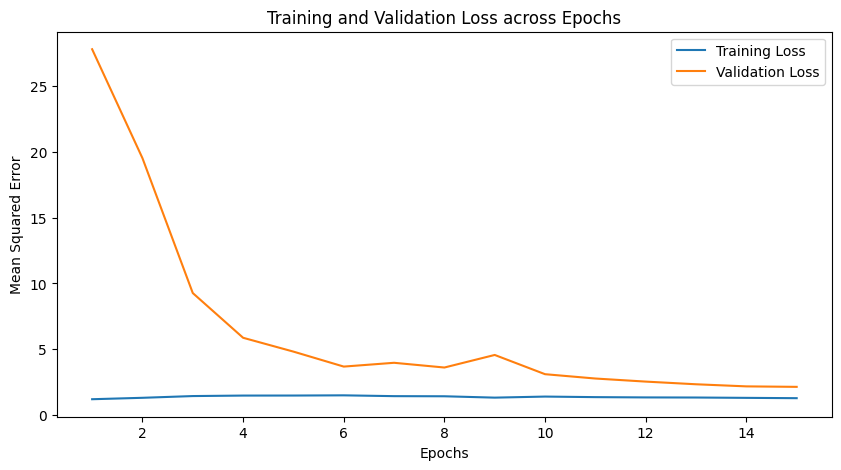

Fold 2/5


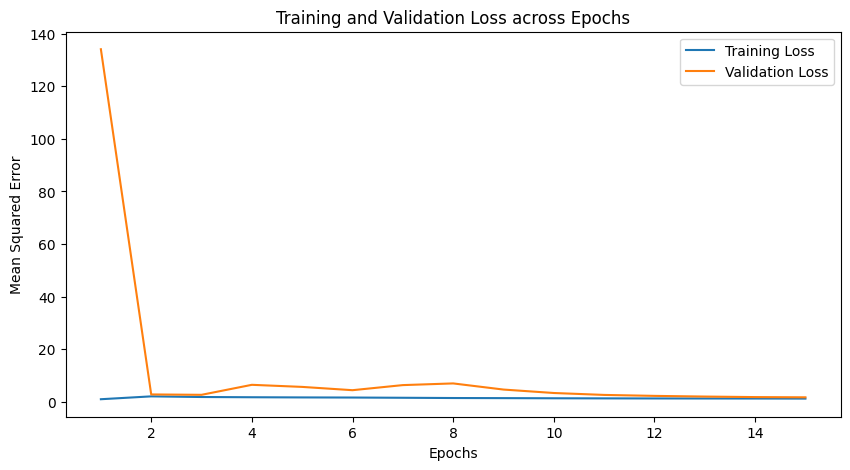

Fold 3/5


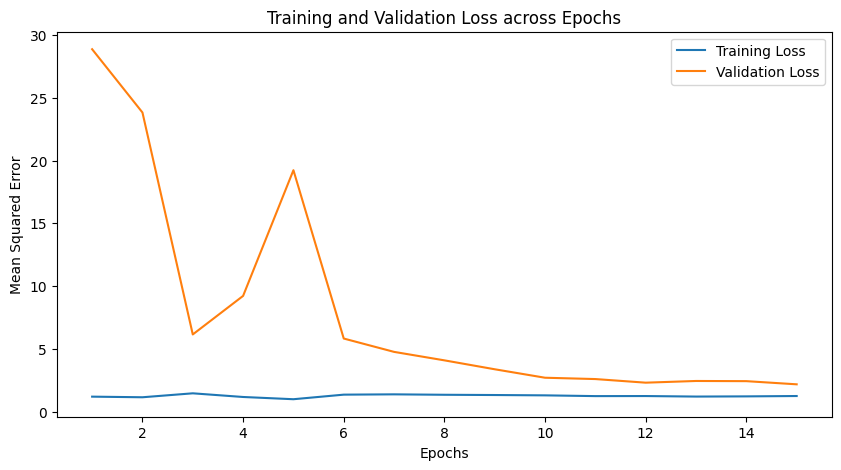

Fold 4/5


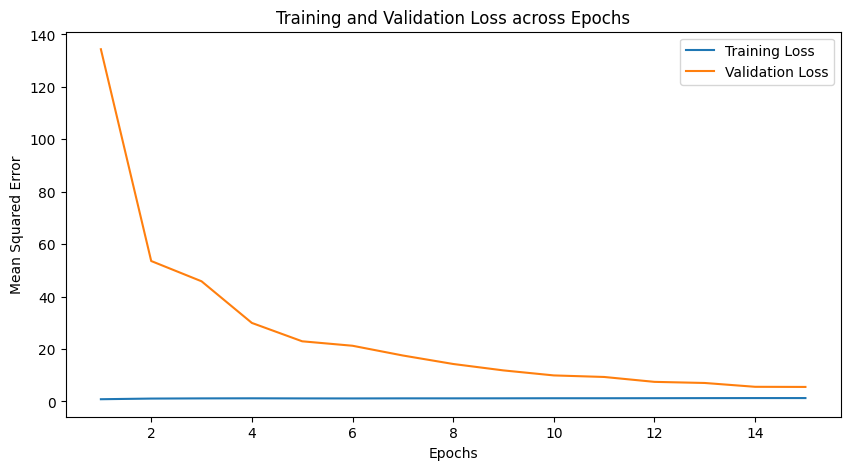

Fold 5/5


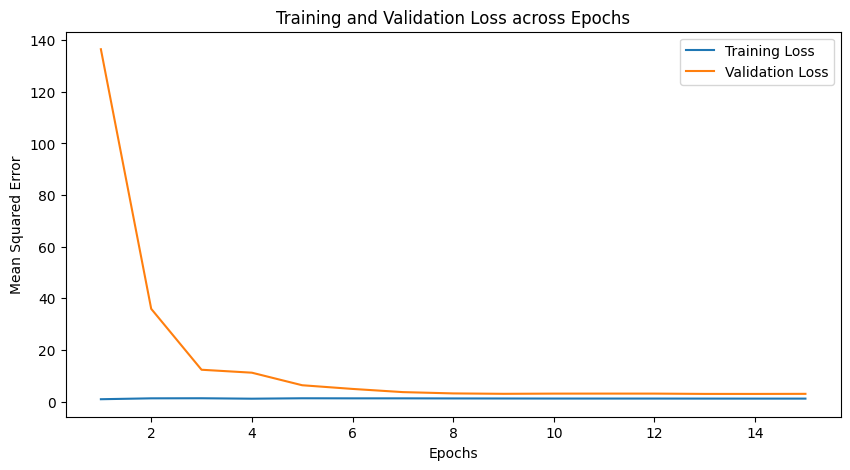

Mean MSE Score: 2.925579565414871, Standard Deviation: 1.373162595515108
Mean R2 Score: 0.3258137372252058, Standard Deviation: 0.43199378326953647
Mean MAPE Score: 0.35069936513900757, Standard Deviation: 0.167952299118042


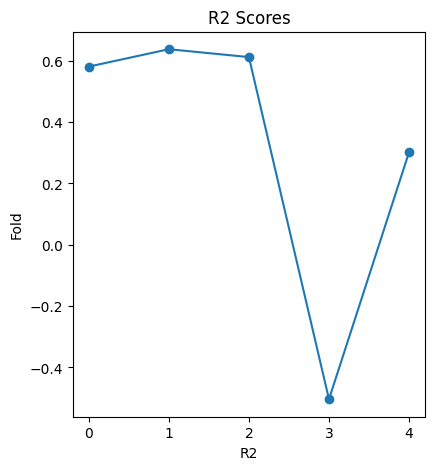

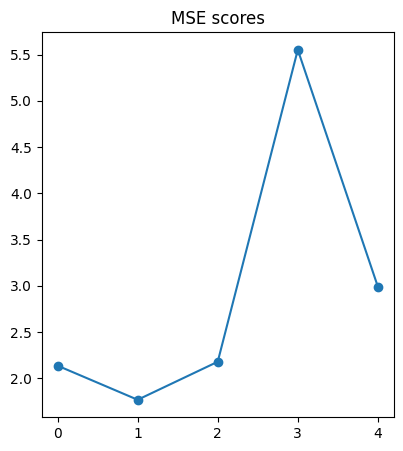

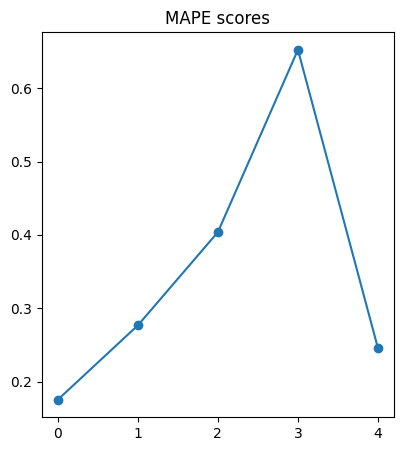

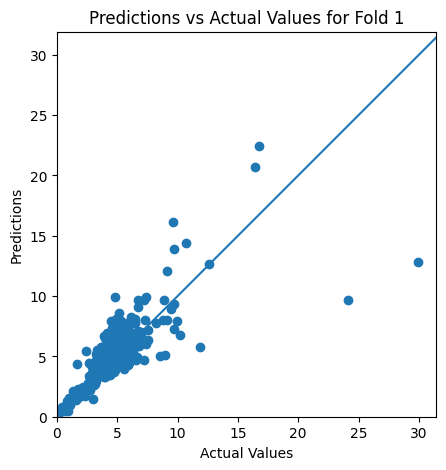

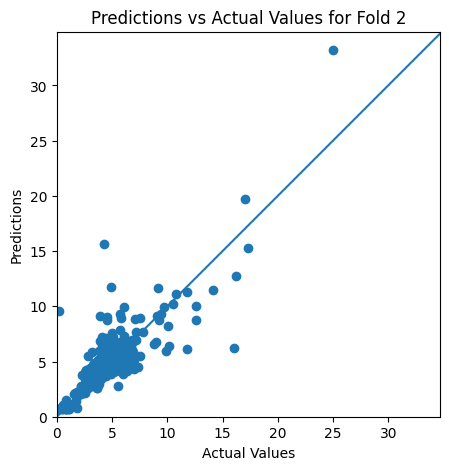

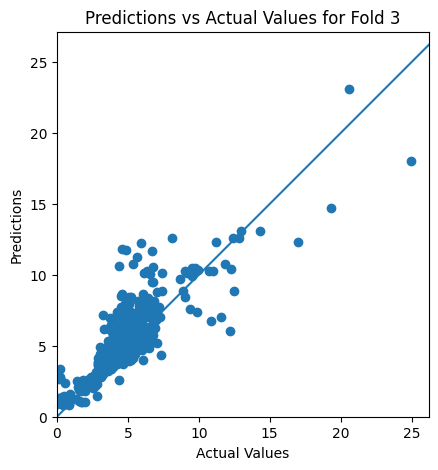

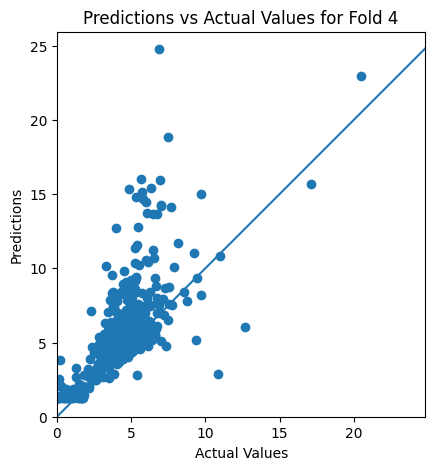

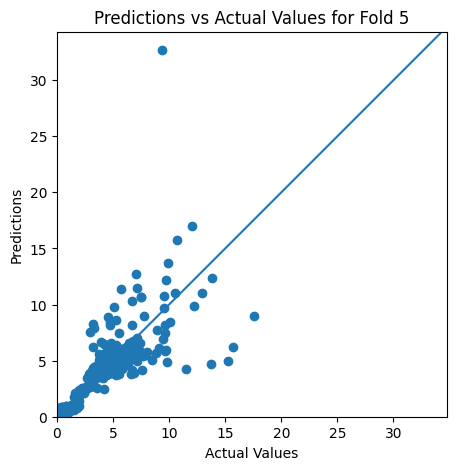

In [1322]:
from sklearn.model_selection import KFold
from torch.optim import lr_scheduler

num_epochs = 15
num_splits = 5
kfold = KFold(n_splits=num_splits, shuffle=True, random_state=42)

# Initializing lists to store losses for each fold
train_losses = []
val_losses = []
mses = []
r2_scores = []
fold_targets = []
fold_predictions = []
fold_rating_predictions = []
fold_input_ratings = []
fold_colours = []
mapes = []

# Begin cross-validation
f = 0
for fold, (train_idx, val_idx) in enumerate(kfold.split(df_model_rating, df_model_ytm['Yld to Mty (Mid)'])):
    model_ytm = ModelYTM(num_features_ytm=num_features_ytm)
    model_ytm.load_state_dict(torch.load(f'model_ytm_fold{f+1}.pth'))
    model_ytm.eval()
    for param in model_ytm.parameters():
        param.requires_grad = False
    model_rating = ModelRating(n_features_rtg=n_features_rtg)
    model = Model(model_rating, model_ytm)

    optimizer = optim.Adagrad(model_rating.parameters(), lr=0.1)
    # scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.5)
    loss_function = nn.MSELoss()
    # Initialize lists to store epoch losses for this fold
    epoch_train_losses = []
    epoch_val_losses = []
    epoch_r2_scores = []
    
    print(f'Fold {fold+1}/{num_splits}')

    # Further splitting the data into model1 and model2 inputs
    X_model1_train_fold = X_num_rtg[train_idx].copy()
    X_model2_train_fold = X_num[train_idx].astype('float64').copy()
    X_model1_val_fold = X_num_rtg[val_idx].copy()
    X_model2_val_fold = X_num[val_idx].astype('float64').copy()
    y_train_fold = df_model_ytm['Yld to Mty (Mid)'].to_numpy()[train_idx]
    y_val_fold = df_model_ytm['Yld to Mty (Mid)'].to_numpy()[val_idx]

    # Scale X_num for both training and validation using the same scaler
    for i in range(X_model2_train_fold.shape[1]):
        if df_model_ytm.columns[i] == 'Issuer Rating':
            scaler = issuer_rating_scaler
        else:
            scaler = StandardScaler()
        X_model2_train_fold[:, i] = scaler.fit_transform(X_model2_train_fold[:, i].reshape(-1, 1)).flatten()
        X_model2_val_fold[:, i] = scaler.transform(X_model2_val_fold[:, i].reshape(-1, 1)).flatten()


    # Scale X_num_rtg for both training and validation using the same scaler
    for i in range(X_model1_train_fold.shape[1]):
        if df_model_rating.columns[i] == 'Issuer Rating':
            scaler = issuer_rating_scaler
        else:
            scaler = StandardScaler()
        X_model1_train_fold[:, i] = scaler.fit_transform(X_model1_train_fold[:, i].reshape(-1, 1)).flatten()
        X_model1_val_fold[:, i] = scaler.transform(X_model1_val_fold[:, i].reshape(-1, 1)).flatten()

    # Training loop
    for epoch in range(num_epochs):
        running_train_loss = 0.0
        running_val_loss = 0.0

        # Training phase
        model.train()
        for model1_in, model2_in_num, target in zip(X_model1_train_fold, X_model2_train_fold, y_train_fold):
            model1_in = torch.tensor(model1_in, dtype=torch.float32).unsqueeze(0)
            model2_in_num = torch.tensor(model2_in_num, dtype=torch.float32).unsqueeze(0)
            target = torch.tensor(target, dtype=torch.float32).unsqueeze(0)

            loss = train_step(model1_in, model2_in_num, target, optimizer)
            running_train_loss += loss.item()

        # Validation phase
        model.eval()
        with torch.no_grad():
            outputs = []
            targets = []
            output_ratings = []
            input_ratings = []
            colours = []
            for model1_in, model2_in_num, target in zip(X_model1_val_fold, X_model2_val_fold, y_val_fold):
                model1_in = torch.tensor(model1_in, dtype=torch.float32).unsqueeze(0)
                model2_in_num = torch.tensor(model2_in_num, dtype=torch.float32).unsqueeze(0)
                target = torch.tensor(target, dtype=torch.float32).unsqueeze(0)

                output_rating, output = model(model1_in, model2_in_num)

                output = output[0]
                loss = loss_function(output, target)
                running_val_loss += loss.item()

                outputs.append(output.numpy())
                targets.append(target.numpy())
                output_ratings.append(output_rating.numpy()[0])
                input_ratings.append(model2_in_num[:,1].numpy())
                colour = 'green'

                # If the value in the third column is non-zero, change the color to red
                if model1_in[0, 11] > 0:
                    colour = 'red'

                colours.append(colour)

            # Calculate R2 score
        r2 = r2_score(np.concatenate(targets), np.concatenate(outputs))
        mape = mean_absolute_percentage_error(np.concatenate(targets), np.concatenate(outputs))
        
        # Calculate and store epoch losses
        epoch_train_loss = running_train_loss / len(X_model1_train_fold)
        epoch_val_loss = running_val_loss / len(X_model1_val_fold)
        epoch_train_losses.append(epoch_train_loss)
        epoch_val_losses.append(epoch_val_loss)
    # Store R2 scores for this fold
    r2_scores.append(r2)
    mse = epoch_val_loss
    mapes.append(mape)
    # Store losses for this fold
    train_losses.append(epoch_train_losses)
    val_losses.append(epoch_val_losses)
    fold_predictions.append(np.concatenate(outputs))
    fold_targets.append(np.concatenate(targets))
    fold_rating_predictions.append(np.concatenate(output_ratings))
    fold_input_ratings.append(np.concatenate(input_ratings))
    fold_colours.append(colours)

    # Plotting
    plt.figure(figsize=(10, 5))

    # Create an x-axis range
    x_values = range(1, num_epochs + 1)

    # Plot both training and validation MSE values
    plt.plot(x_values, train_losses[f], label='Training Loss')
    plt.plot(x_values, val_losses[f], label='Validation Loss')

    # Adding title and labels
    plt.title('Training and Validation Loss across Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Squared Error')
    plt.legend()

    # Show the plot
    plt.show()
    f += 1

    mses.append(mse)
    
sd_r2 = np.std(r2_scores)
print(f'Mean MSE Score: {np.mean(mses)}, Standard Deviation: {np.std(mses)}')
print(f'Mean R2 Score: {np.mean(r2_scores)}, Standard Deviation: {sd_r2}')
print(f'Mean MAPE Score: {np.mean(mapes)}, Standard Deviation: {np.std(mapes)}')

# Plot the predictions against the actual values for each fold
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(r2_scores, marker='o')
plt.title(f'R2 Scores')
plt.xlabel('R2')
plt.ylabel('Fold')
plt.show()

# Plot the MSE scores
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(mses, marker='o')
plt.title('MSE scores')
plt.show()

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(mapes, marker='o')
plt.title('MAPE scores')
plt.show()

for fold in range(num_splits):
    # Plot the predictions against the actual values for each fold
    plt.figure(figsize=(10,5))
    plt.scatter(fold_targets[fold], fold_predictions[fold])
    plt.title(f'Predictions vs Actual Values for Fold {fold+1}')
    plt.xlabel('Actual Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim([0,plt.xlim()[1]])
    plt.ylim([0,plt.ylim()[1]])
    _ = plt.plot([-100, 100], [-100, 100])
    plt.show()


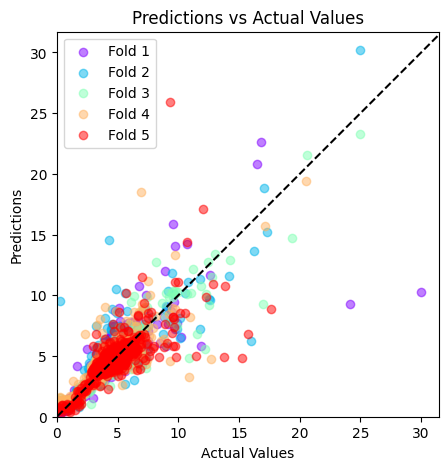

In [1319]:
# Create color map with a unique color for each fold
colors = plt.cm.rainbow(np.linspace(0, 1, num_splits))

# Create the figure
plt.figure(figsize=(10,5))

for fold in range(num_splits):
    # Scatter the predictions against the actual values for each fold
    plt.scatter(fold_targets[fold], fold_predictions[fold], color=colors[fold], alpha=0.5, label=f'Fold {fold+1}')

# Set title and labels
plt.title('Predictions vs Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])

# Plot the identity line
_ = plt.plot([-100, 100], [-100, 100], color='black', linestyle='--')

# Add a legend
plt.legend()

# Show the plot
plt.show()


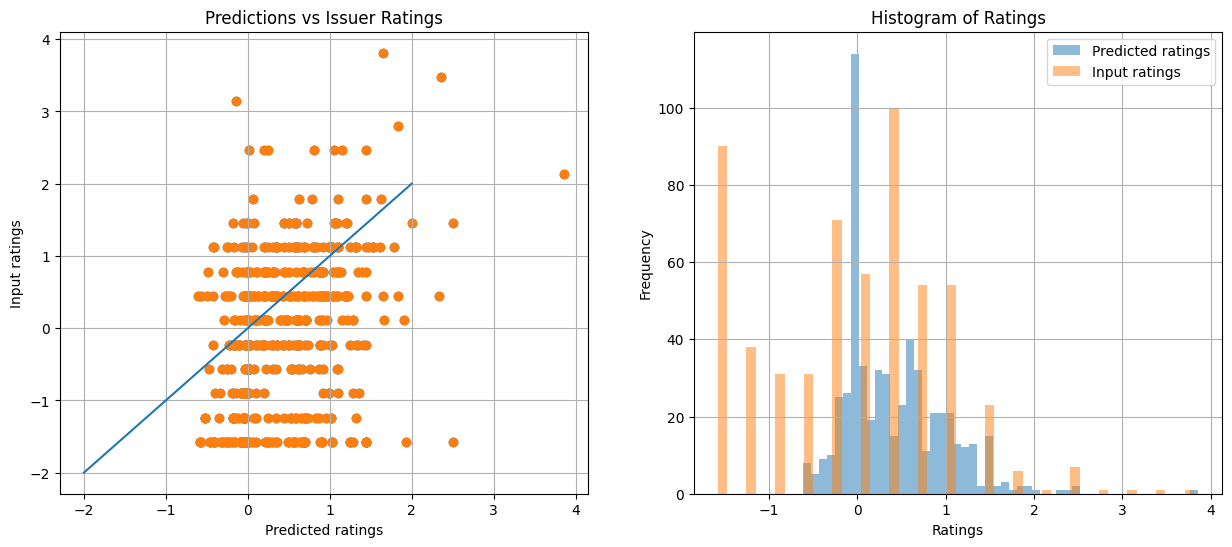

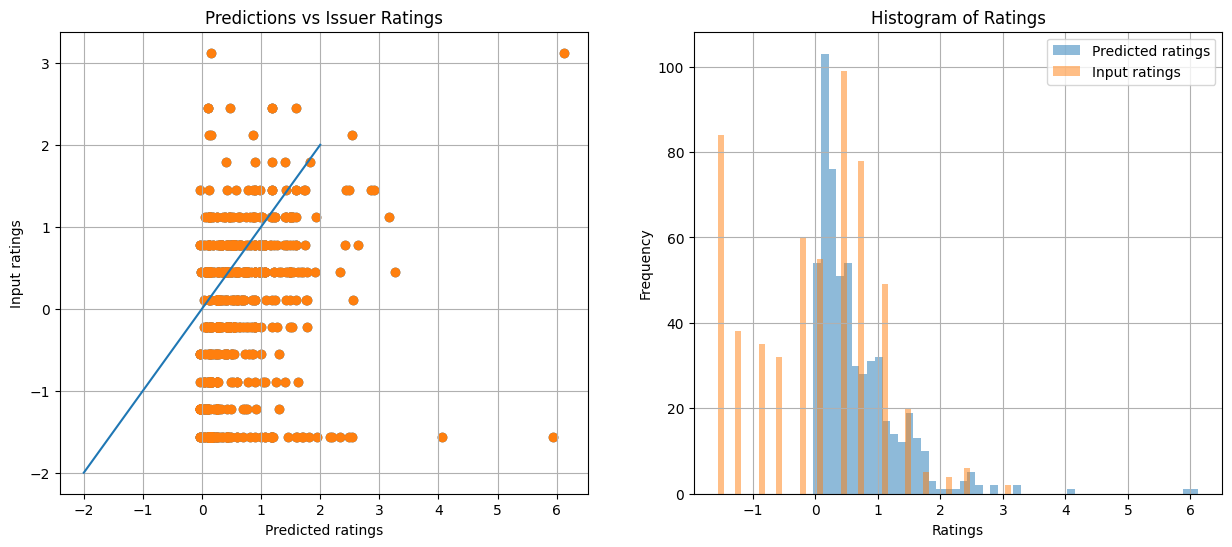

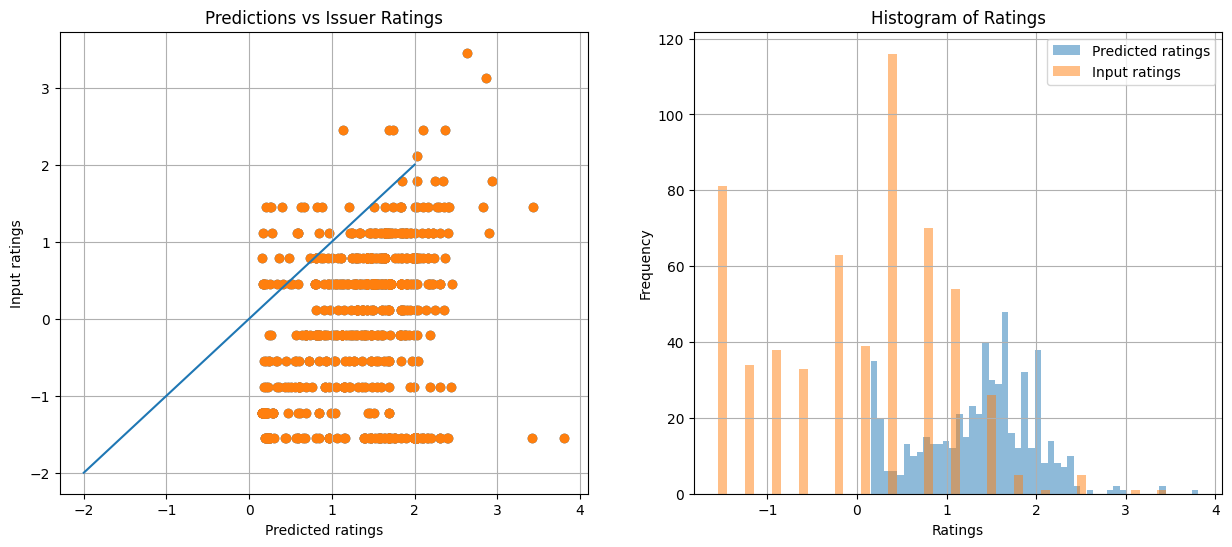

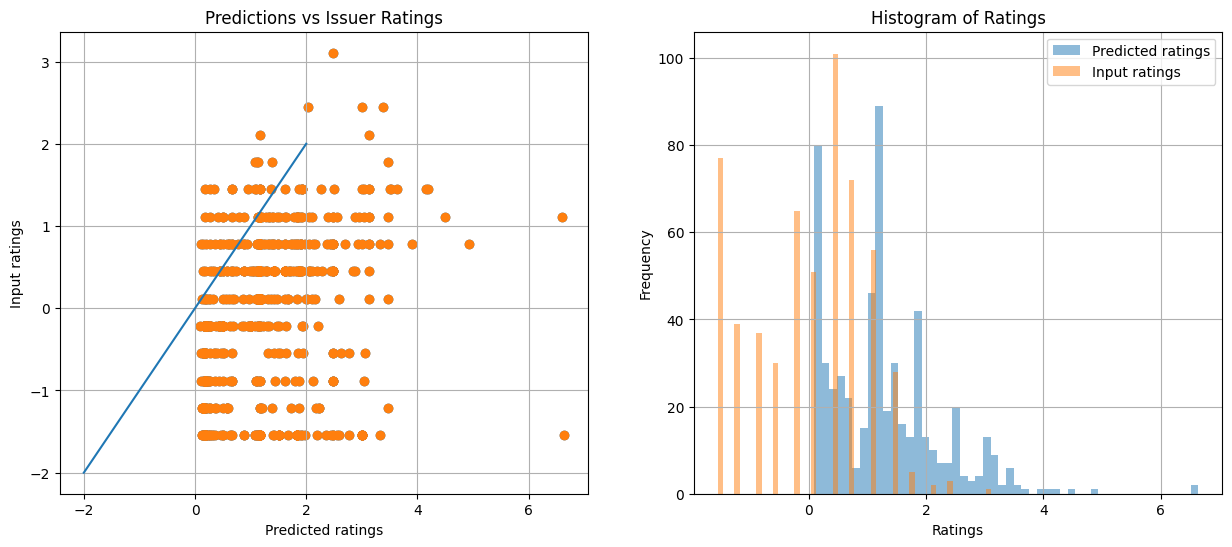

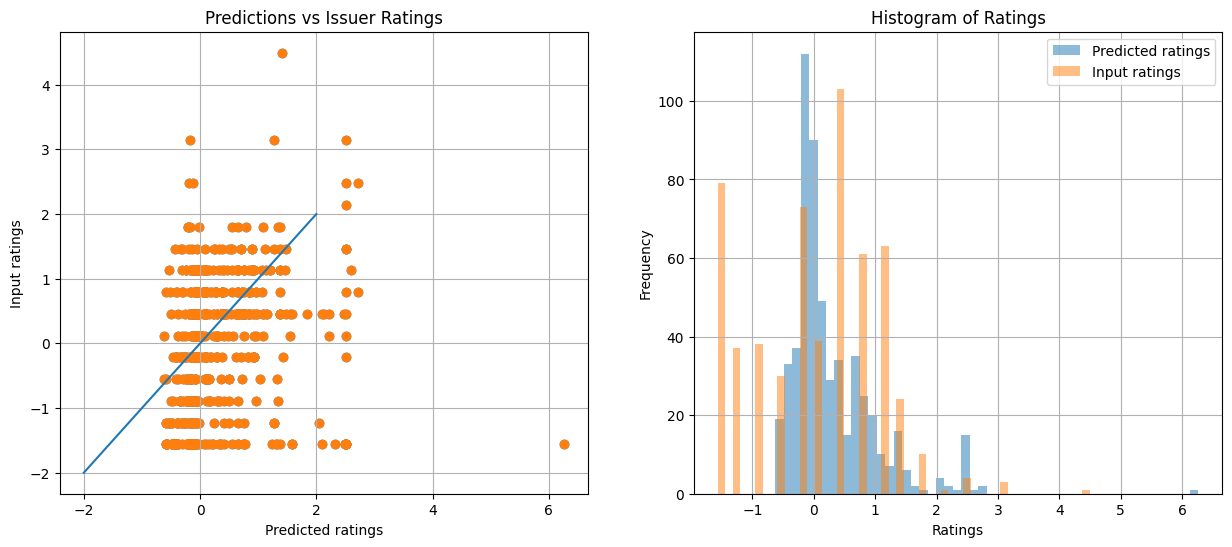

In [1323]:
for i in range(5):
    outputs1 = fold_rating_predictions[i]
    inputs = fold_input_ratings[i]

    # Create a figure with a specific size
    fig = plt.figure(figsize=(15, 6))

    # Create a subplot for the scatter plot
    ax1 = fig.add_subplot(121)  # 121 means: grid 1x2 and use the first cell
    ax1.scatter(outputs1, inputs, marker='o')
    ax1.set_xlabel('Predicted ratings')
    ax1.set_ylabel('Input ratings')
    ax1.set_title('Predictions vs Issuer Ratings')
    ax1.grid(True)
    ax1.scatter(outputs1, inputs, marker='o')#, c=fold_colours[i])
    ax1.plot([-2, 2], [-2, 2])

    # Create a subplot for the histogram of predicted ratings
    ax2 = fig.add_subplot(122)  # 122 means: grid 1x2 and use the second cell
    ax2.hist(outputs1, bins=50, alpha=0.5, label='Predicted ratings')
    ax2.hist(inputs, bins=50, alpha=0.5, label='Input ratings')
    ax2.set_xlabel('Ratings')
    ax2.set_ylabel('Frequency')
    ax2.set_title('Histogram of Ratings')
    ax2.grid(True)
    ax2.legend(loc='upper right')

    plt.show()

Fold 1/5


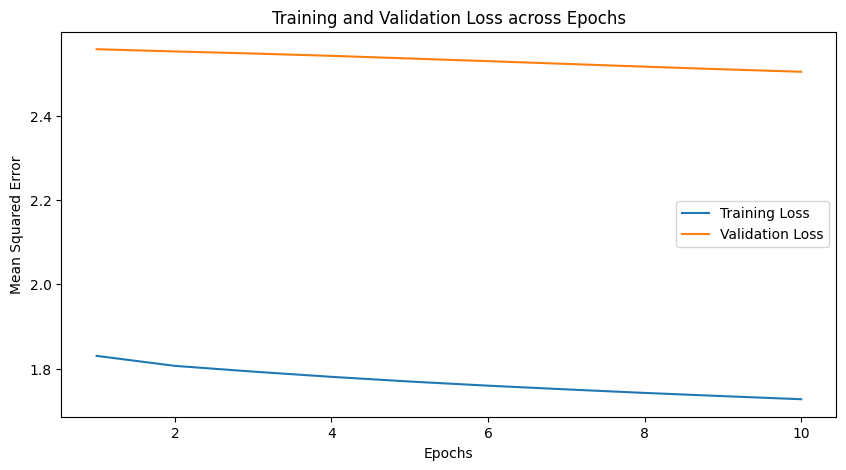

Fold 2/5


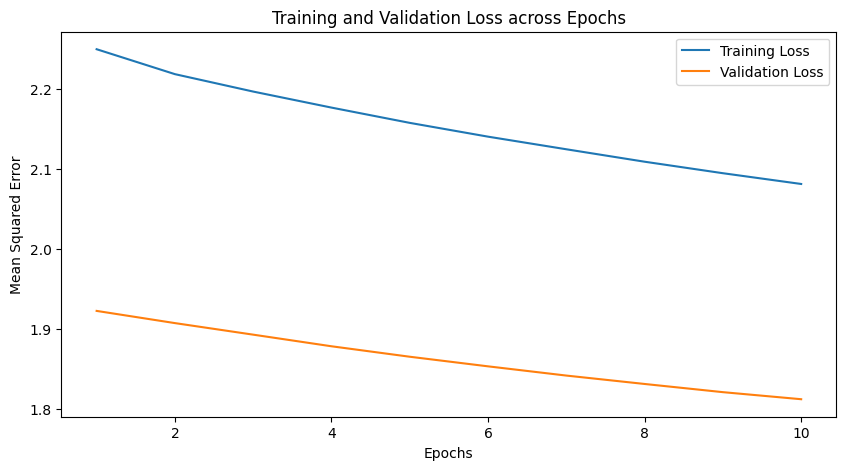

Fold 3/5


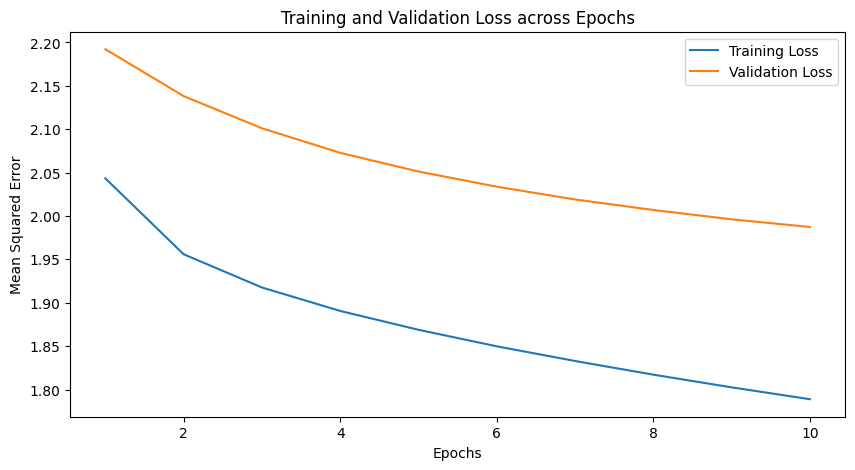

Fold 4/5


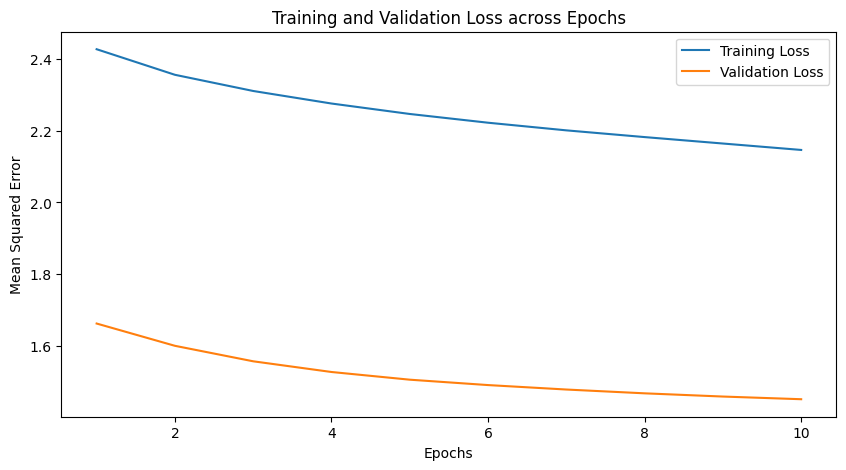

Fold 5/5


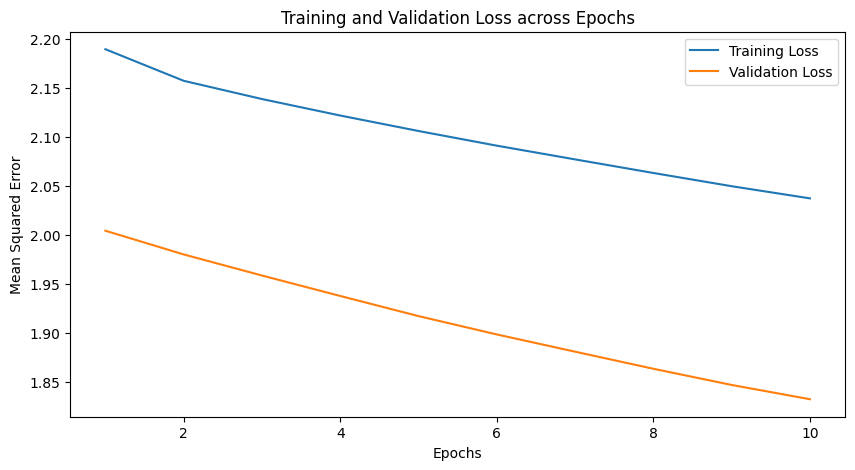

Mean MSE Score: 1.9174857389114852, Standard Deviation: 0.3418855328736734
Mean R2 Score: 0.5926391575153227, Standard Deviation: 0.04856238965448593
Mean MAPE Score: 0.2315690517425537, Standard Deviation: 0.05445026233792305


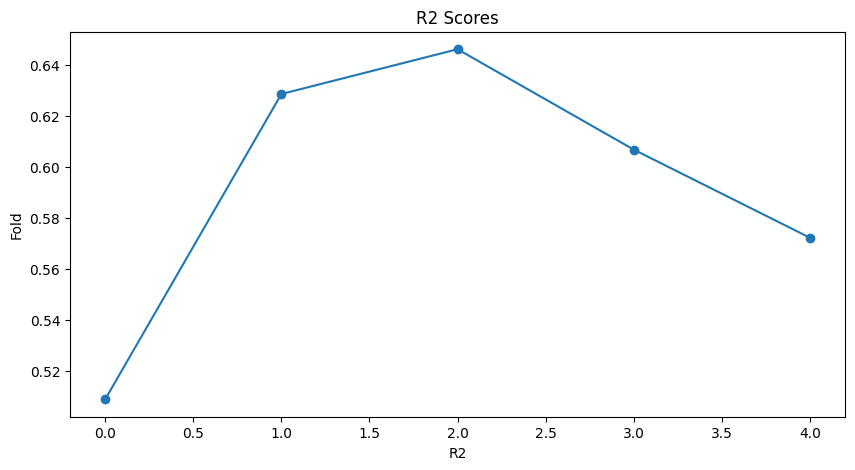

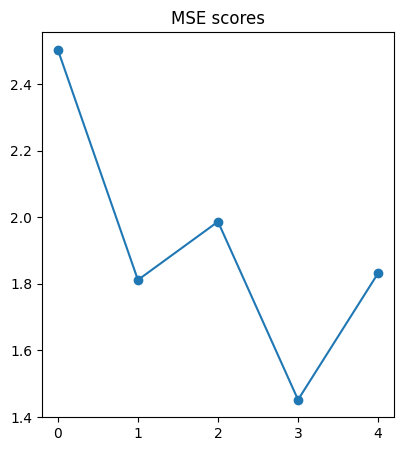

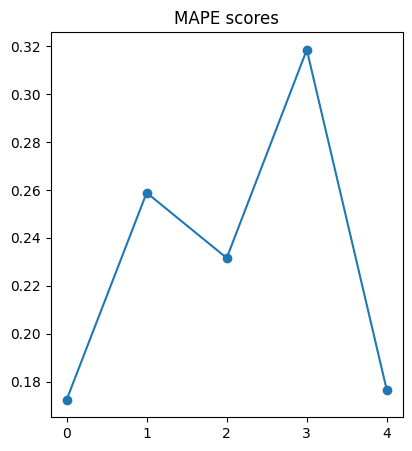

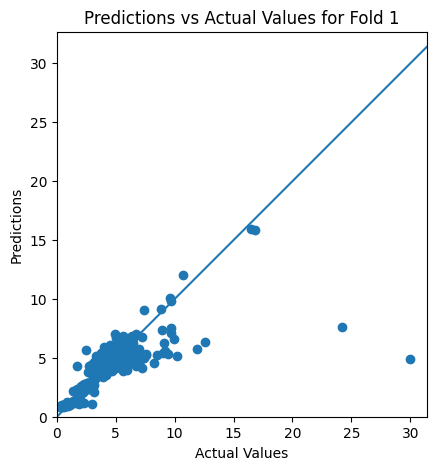

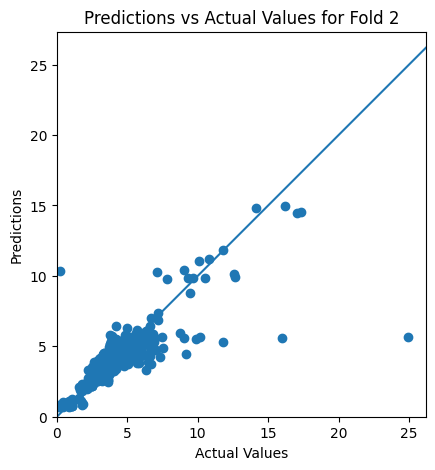

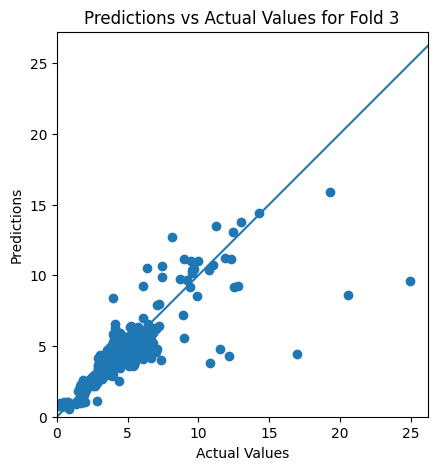

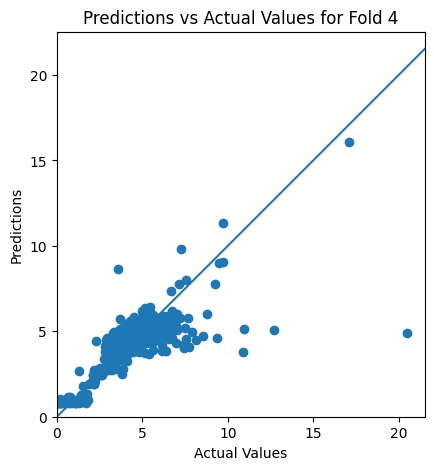

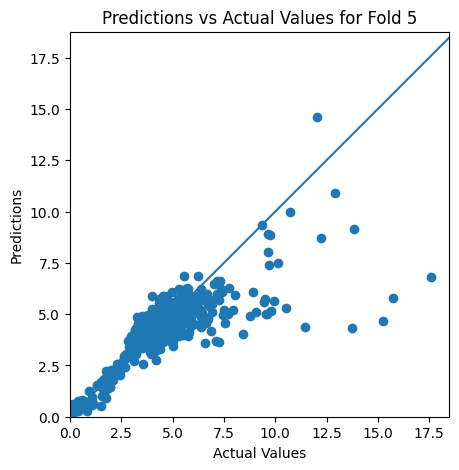

In [ ]:
from sklearn.model_selection import KFold

num_epochs = 10
num_splits = 5
kfold = KFold(n_splits=num_splits, shuffle=True, random_state=42)

# Initializing lists to store losses for each fold
train_losses = []
val_losses = []
mses = []
r2_scores = []
mapes = []
fold_targets = []
fold_predictions = []

# Begin cross-validation
f = 0
for fold, (train_idx, val_idx) in enumerate(kfold.split(df_model_rating, df_model_ytm['Yld to Mty (Mid)'])):
    model_ytm = ModelYTM(num_features_ytm=num_features_ytm)
    model_ytm.load_state_dict(torch.load(f'model_ytm_fold{f+1}.pth'))
    model_ytm.eval()
    model_rating = ModelRating(n_features_rtg=n_features_rtg)
    model = Model(model_rating, model_ytm)

    optimizer = optim.Adam(model_rating.parameters(), lr=0.0001)
    loss_function = nn.MSELoss()
    # Initialize lists to store epoch losses for this fold
    epoch_train_losses = []
    epoch_val_losses = []
    epoch_r2_scores = []
    print(f'Fold {fold+1}/{num_splits}')

    # Further splitting the data into model1 and model2 inputs
    X_model1_train_fold = X_num_rtg[train_idx].copy()
    X_model2_train_fold = X_num[train_idx].astype('float64').copy()
    X_model1_val_fold = X_num_rtg[val_idx].copy()
    X_model2_val_fold = X_num[val_idx].astype('float64').copy()
    y_train_fold = df_model_ytm['Yld to Mty (Mid)'].to_numpy()[train_idx]
    y_val_fold = df_model_ytm['Yld to Mty (Mid)'].to_numpy()[val_idx]

    

    # Scale X_num for both training and validation using the same scaler
    for i in range(X_model2_train_fold.shape[1]):
        if df_model_ytm.columns[i] == 'Issuer Rating':
            scaler = issuer_rating_scaler
        else:
            scaler = StandardScaler()
        X_model2_train_fold[:, i] = scaler.fit_transform(X_model2_train_fold[:, i].reshape(-1, 1)).flatten()
        X_model2_val_fold[:, i] = scaler.transform(X_model2_val_fold[:, i].reshape(-1, 1)).flatten()


    # Scale X_num_rtg for both training and validation using the same scaler
    for i in range(X_model1_train_fold.shape[1]):
        if df_model_rating.columns[i] == 'Issuer Rating':
            scaler = issuer_rating_scaler
        else:
            scaler = StandardScaler()
        X_model1_train_fold[:, i] = scaler.fit_transform(X_model1_train_fold[:, i].reshape(-1, 1)).flatten()
        X_model1_val_fold[:, i] = scaler.transform(X_model1_val_fold[:, i].reshape(-1, 1)).flatten()

    # Training loop
    for epoch in range(num_epochs):
        running_train_loss = 0.0
        running_val_loss = 0.0

        # Training phase
        model.train()
        for model1_in, model2_in_num, target in zip(X_model1_train_fold, X_model2_train_fold, y_train_fold):
            model1_in = torch.tensor(model1_in, dtype=torch.float32).unsqueeze(0)
            model2_in_num = torch.tensor(model2_in_num, dtype=torch.float32).unsqueeze(0)
            target = torch.tensor(target, dtype=torch.float32).unsqueeze(0)

            loss = train_step(model1_in, model2_in_num, target, optimizer)
            running_train_loss += loss.item()

        # Validation phase
        model.eval()
        with torch.no_grad():
            outputs = []
            targets = []
            for model1_in, model2_in_num, target in zip(X_model1_val_fold, X_model2_val_fold, y_val_fold):
                model1_in = torch.tensor(model1_in, dtype=torch.float32).unsqueeze(0)
                model2_in_num = torch.tensor(model2_in_num, dtype=torch.float32).unsqueeze(0)
                target = torch.tensor(target, dtype=torch.float32).unsqueeze(0)

                output_rating, output = model(model1_in, model2_in_num)
                # print(output_rating)
                output = output[0]
                loss = loss_function(output, target)
                running_val_loss += loss.item()

                outputs.append(output.numpy())
                targets.append(target.numpy())

            # Calculate R2 score
        r2 = r2_score(np.concatenate(targets), np.concatenate(outputs))
        mape = mean_absolute_percentage_error(np.concatenate(targets), np.concatenate(outputs))
        
        # Calculate and store epoch losses
        epoch_train_loss = running_train_loss / len(X_model1_train_fold)
        epoch_val_loss = running_val_loss / len(X_model1_val_fold)
        epoch_train_losses.append(epoch_train_loss)
        epoch_val_losses.append(epoch_val_loss)
    # Store R2 scores for this fold
    r2_scores.append(r2)
    mse = epoch_val_loss
    mapes.append(mape)
    # Store losses for this fold
    train_losses.append(epoch_train_losses)
    val_losses.append(epoch_val_losses)
    fold_predictions.append(np.concatenate(outputs))
    fold_targets.append(np.concatenate(targets))

    # Plotting
    plt.figure(figsize=(10, 5))

    # Create an x-axis range
    x_values = range(1, num_epochs + 1)

    # Plot both training and validation MSE values
    plt.plot(x_values, train_losses[f], label='Training Loss')
    plt.plot(x_values, val_losses[f], label='Validation Loss')

    # Adding title and labels
    plt.title('Training and Validation Loss across Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Squared Error')
    plt.legend()

    # Show the plot
    plt.show()
    f += 1

    mses.append(mse)
    
sd_r2 = np.std(r2_scores)
print(f'Mean MSE Score: {np.mean(mses)}, Standard Deviation: {np.std(mses)}')
print(f'Mean R2 Score: {np.mean(r2_scores)}, Standard Deviation: {sd_r2}')
print(f'Mean MAPE Score: {np.mean(mapes)}, Standard Deviation: {np.std(mapes)}')

# Plot the predictions against the actual values for each fold
plt.figure(figsize=(10,5))
plt.plot(r2_scores, marker='o')
plt.title(f'R2 Scores')
plt.xlabel('R2')
plt.ylabel('Fold')
plt.show()

# Plot the MSE scores
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(mses, marker='o')
plt.title('MSE scores')
plt.show()

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(mapes, marker='o')
plt.title('MAPE scores')
plt.show()

for fold in range(num_splits):
    # Plot the predictions against the actual values for each fold
    plt.figure(figsize=(10,5))
    plt.scatter(fold_targets[fold], fold_predictions[fold])
    plt.title(f'Predictions vs Actual Values for Fold {fold+1}')
    plt.xlabel('Actual Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim([0,plt.xlim()[1]])
    plt.ylim([0,plt.ylim()[1]])
    _ = plt.plot([-100, 100], [-100, 100])
    plt.show()
